In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.distance import distance_riemann
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from journal_style import EnableJournalStylePlotting
from tSSA import t_SSA
import scipy
import torch

import pathlib

import pickle
import re

%matplotlib inline

In [13]:
ts = pd.read_csv("Accelerometer Data 0000.txt", delimiter=',')

In [14]:
print(ts)

       Time (s)   X (m/s2)   Y (m/s2)   Z (m/s2)   R (m/s2)   Theta (deg)  \
0      0.000000  -1.349913   5.031966   8.939438  10.346811     30.233562   
1      0.003905  -1.311585   5.031966   8.671144  10.110869     30.951136   
2      0.007809  -1.311585   4.955311   8.517834   9.941270     31.039120   
3      0.011714  -1.273258   5.031966   8.517834   9.974736     31.357094   
4      0.015619  -1.158275   5.070294   8.441178   9.914785     31.638704   
...         ...        ...        ...        ...        ...           ...   
7154  27.932896  -0.928309   4.802001   8.364523   9.689490     30.315699   
7155  27.936800  -0.813326   4.725346   8.096230   9.409534     30.635283   
7156  27.940706  -0.698343   4.725346   7.981247   9.301445     30.899961   
7157  27.944609  -0.621688   4.725346   7.942919   9.263118     30.965429   
7158  27.948515  -0.506705   4.725346   7.866264   9.190416     31.138443   

       Phi (deg)  
0     105.017014  
1     104.609131  
2     104.825241  

In [15]:
ts_XYZ = ts.iloc[:, 0:4]
ts_XYZ.set_index('Time (s)', inplace=True)

In [16]:
print(ts_XYZ)

           X (m/s2)  Y (m/s2)  Z (m/s2)
Time (s)                               
0.000000  -1.349913  5.031966  8.939438
0.003905  -1.311585  5.031966  8.671144
0.007809  -1.311585  4.955311  8.517834
0.011714  -1.273258  5.031966  8.517834
0.015619  -1.158275  5.070294  8.441178
...             ...       ...       ...
27.932896 -0.928309  4.802001  8.364523
27.936800 -0.813326  4.725346  8.096230
27.940706 -0.698343  4.725346  7.981247
27.944609 -0.621688  4.725346  7.942919
27.948515 -0.506705  4.725346  7.866264

[7159 rows x 3 columns]


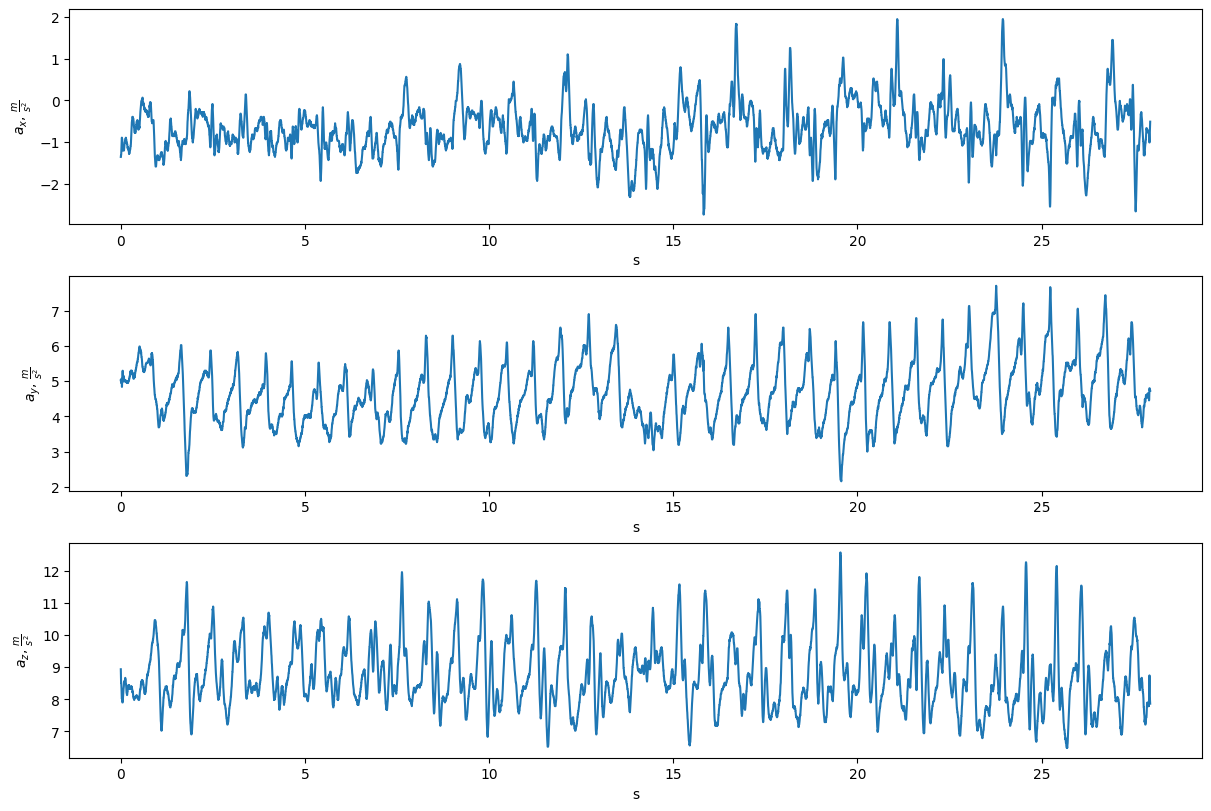

In [17]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(ts_XYZ[' X (m/s2)'])
ax[0].set_ylabel(r'$a_x$, $\frac{m}{s^2}$')
ax[0].set_xlabel('s')
ax[1].plot(ts_XYZ[' Y (m/s2)'], label=r'y, $\frac{m}{s^2}$')
ax[1].set_ylabel(r'$a_y$, $\frac{m}{s^2}$')
ax[1].set_xlabel('s')
ax[2].plot(ts_XYZ[' Z (m/s2)'], label=r'z, $\frac{m}{s^2}$')
ax[2].set_ylabel(r'$a_z$, $\frac{m}{s^2}$')
ax[2].set_xlabel('s')



plt.show()

In [18]:
ts_index = ts.iloc[:, 1:4]

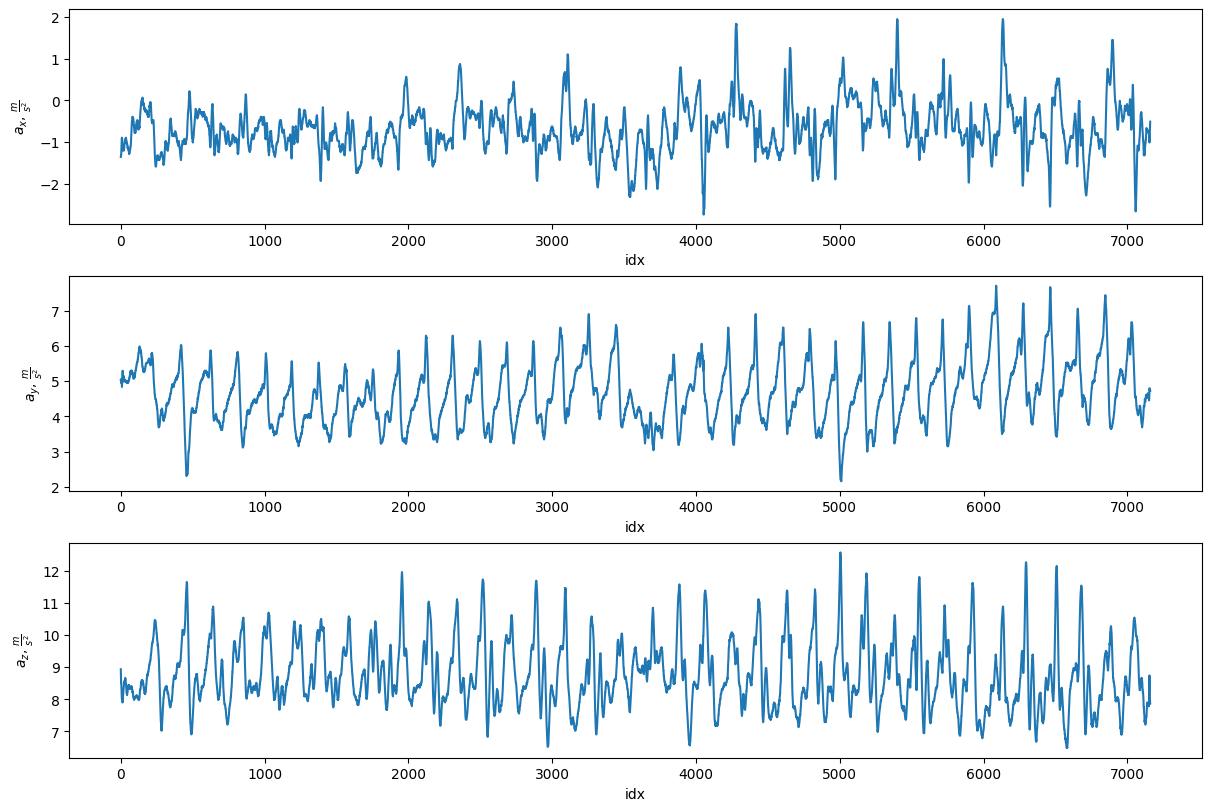

In [19]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(ts_index[' X (m/s2)'])
ax[0].set_ylabel(r'$a_x$, $\frac{m}{s^2}$')
ax[0].set_xlabel('idx')
ax[1].plot(ts_index[' Y (m/s2)'], label=r'y, $\frac{m}{s^2}$')
ax[1].set_ylabel(r'$a_y$, $\frac{m}{s^2}$')
ax[1].set_xlabel('idx')
ax[2].plot(ts_index[' Z (m/s2)'], label=r'z, $\frac{m}{s^2}$')
ax[2].set_ylabel(r'$a_z$, $\frac{m}{s^2}$')
ax[2].set_xlabel('idx')



plt.show()

In [20]:
ts_len = ts_index.shape[0]
'''test_ratio = 0.2

train_ts = ts_index.iloc[:int(ts_len - ts_len // (1 / test_ratio)), :]
test_ts = ts_index.iloc[int(ts_len - ts_len // (1 / test_ratio)):, :]'''

train_ts = ts_index.iloc[:ts_len - 250, :]
test_ts = ts_index.iloc[ts_len - 250:, :]

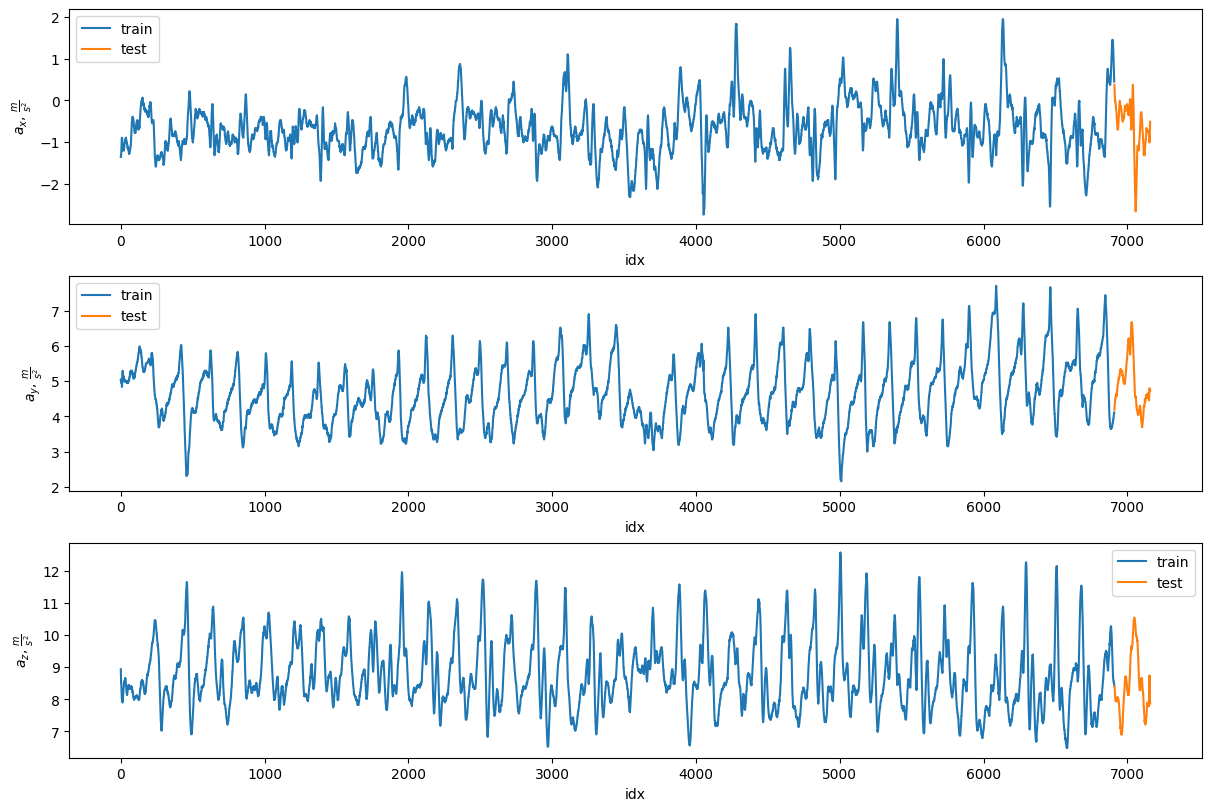

In [21]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(train_ts[' X (m/s2)'], label='train')
ax[0].plot(test_ts[' X (m/s2)'], label='test')
ax[0].set_ylabel(r'$a_x$, $\frac{m}{s^2}$')
ax[0].set_xlabel('idx')
ax[0].legend()
ax[1].plot(train_ts[' Y (m/s2)'], label='train')
ax[1].plot(test_ts[' Y (m/s2)'], label='test')
ax[1].set_ylabel(r'$a_y$, $\frac{m}{s^2}$')
ax[1].set_xlabel('idx')
ax[1].legend()
ax[2].plot(train_ts[' Z (m/s2)'], label='train')
ax[2].plot(test_ts[' Z (m/s2)'], label='test')
ax[2].set_ylabel(r'$a_z$, $\frac{m}{s^2}$')
ax[2].set_xlabel('idx')
ax[2].legend()


plt.show()

# Calculating covariance matrix.

In [22]:
est = 'scm'
w_len = 600 # примерно 2 секунды
k = 1

In [23]:
cov = Covariances(estimator=est)

In [24]:
X = np.array([train_ts.to_numpy().T[:, i * k:i * k + w_len] for i in range(((train_ts.shape[0] - w_len + 1) // k + 1) - 1)])

In [27]:
print(X.shape)

(6310, 3, 600)


In [26]:
'''X_distances = []
for x in X[:-2]:
    dist = np.sum((x - X[-1]).flatten() ** 2)
    X_distances.append(dist)

sorted_X = np.argsort(X_distances)'''

In [28]:
est_cov = cov.transform(X)

In [90]:
'''distances_euclid = []
for cov_matrix in est_cov[:-2]:
    distances_euclid.append(np.sum((cov_matrix - est_cov[-1]).flatten() ** 2))

distances = []
for cov_matrix in est_cov[:-2]:
    distances.append(distance_riemann(cov_matrix, est_cov[-1], squared=True))

sorted = np.argsort(distances)

figure, ax = plt.subplots(figsize=(12, 7))

ax.plot(distances, label='cov riemannian distance')
ax.plot(distances_euclid, label='cov euclidean distance')
#ax.plot(X_distances, label='phase points distance')
ax.legend()'''

In [29]:
print(est_cov[789])

[[ 0.09324614 -0.04092873 -0.01721627]
 [-0.04092873  0.41813502  0.03048536]
 [-0.01721627  0.03048536  0.67462211]]


In [30]:
tangent_space = TangentSpace()
tsp_X = tangent_space.fit_transform(est_cov)

In [31]:
print(tsp_X.shape)

(6310, 6)


# PCA

In [32]:
pca = PCA()
pca.fit(tsp_X)

PCA()

In [33]:
explained_var = np.cumsum(pca.explained_variance_ratio_)

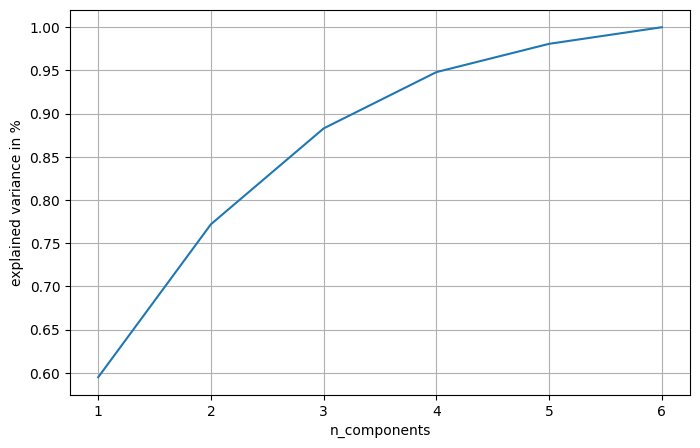

In [34]:
figure, ax = plt.subplots(figsize=(8, 5))

ax.plot([i for i in range(1, pca.n_components_ + 1)], explained_var)
ax.grid()
ax.set_xticks([i for i in range(1, pca.n_components_ + 1)])
ax.set_xlabel("n_components")
ax.set_ylabel("explained variance in %")
plt.show()

In [35]:
tsp_X_pca = PCA(n_components=3).fit_transform(tsp_X)

In [36]:
tsp_X_pca.shape

(6310, 3)

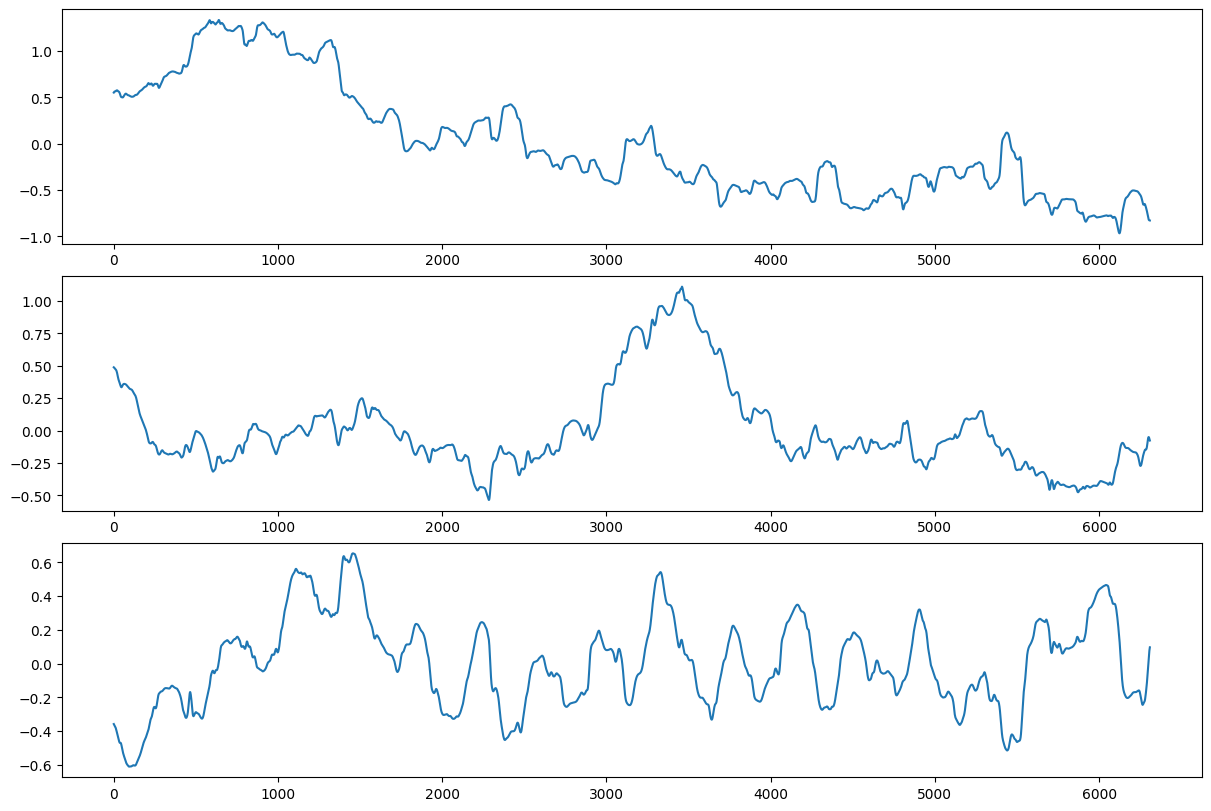

In [37]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(tsp_X_pca[:, 0], label=r'1st component')
ax[1].plot(tsp_X_pca[:, 1], label=r'2nd component')
ax[2].plot(tsp_X_pca[:, 2], label=r'3rd component')



plt.show()

In [38]:
tsp_X_pca_df = pd.DataFrame(tsp_X_pca)

# Individual local forecasting

In [40]:
train_data, test_data = train_ts.to_numpy(), test_ts.to_numpy()

In [41]:
print(train_data.shape)

(6909, 3)


In [48]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [44]:
preds = {i: [] for i in range(train_data.shape[1])}
k = 20

In [50]:
for i in range(train_data.shape[1]):
    hankel_train = HankelMatrix(train_data[:, i], w_len)
    horizon = test_data.shape[0]
    for _ in range(horizon):
            distances = np.sum((hankel_train - hankel_train[-1]) ** 2, axis=1)
            nn = np.argsort(distances)
            nn = nn[nn != len(hankel_train) - 1]
            knn = nn[:k]
            nn_targets = hankel_train[knn + 1, -1]
            preds[i].append(np.mean(nn_targets))
            hankel_train = np.append(hankel_train, [list(hankel_train[-1, 1:]) + [preds[i][-1]]], axis=0)

In [51]:
mse_local = []
mape_local = []

In [52]:
for i in range(train_data.shape[1]):
    mse_local.append(np.mean((preds[i] - test_data[:, i]) ** 2, axis=0))
    mape_local.append(np.mean(np.abs((preds[i] - test_data[:, i]) / test_data[:, i]), axis=0))

    print(f'MSE: {mse_local[i]}; MAPE: {mape_local[i]}')

print(f'Mean by signals: MSE = {np.mean(mse_local)}, MAPE = {np.mean(mape_local)}')

MSE: 0.27091512661055545; MAPE: 1.9325687341007383
MSE: 0.2007462552879441; MAPE: 0.07406737104299378
MSE: 0.22384099184797915; MAPE: 0.04381611072913484
Mean by signals: MSE = 0.23183412458215957, MAPE = 0.6834840719576224


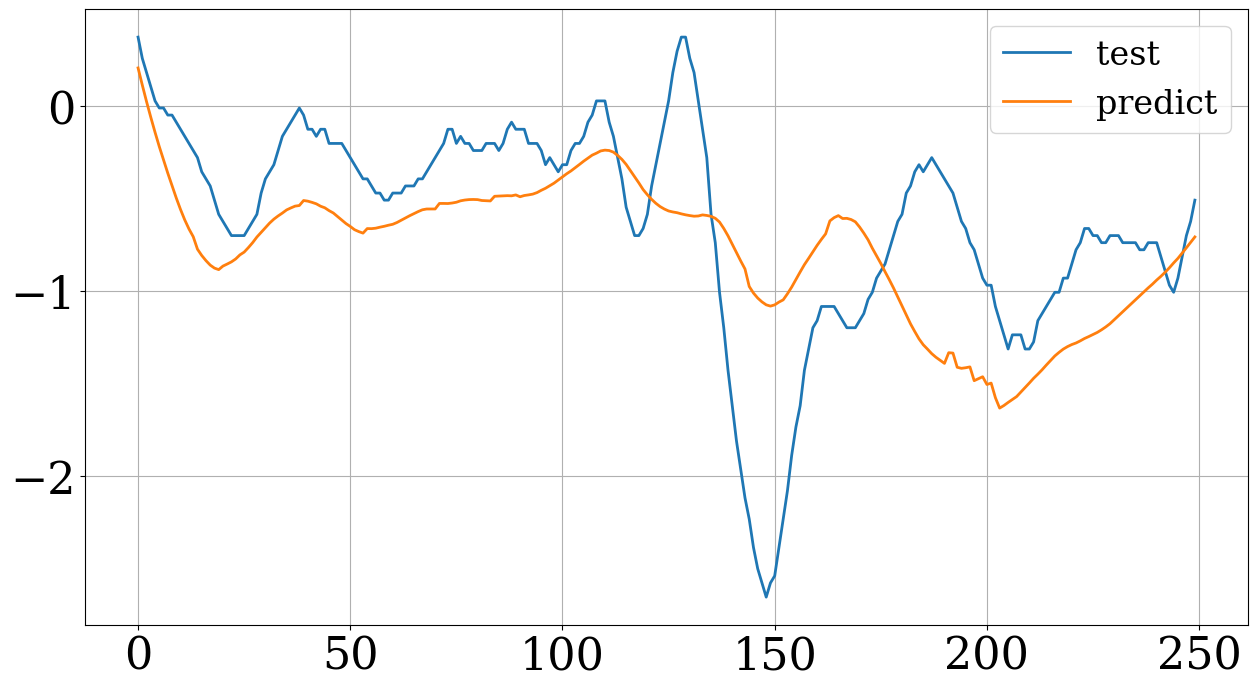

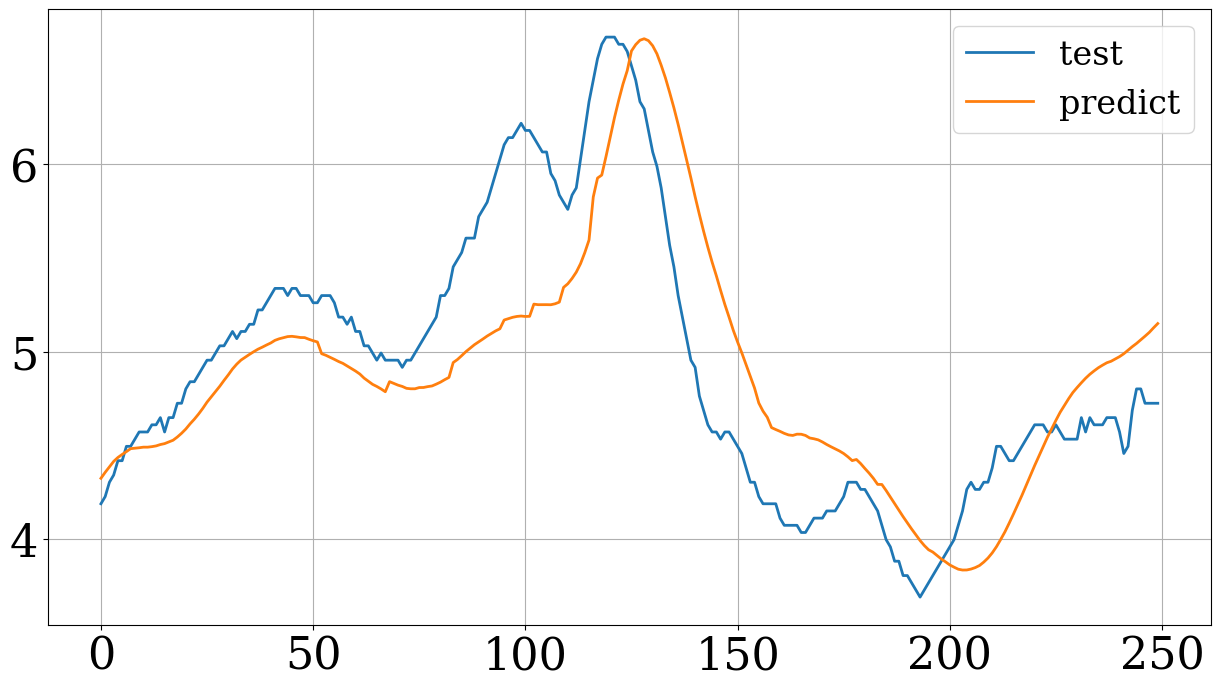

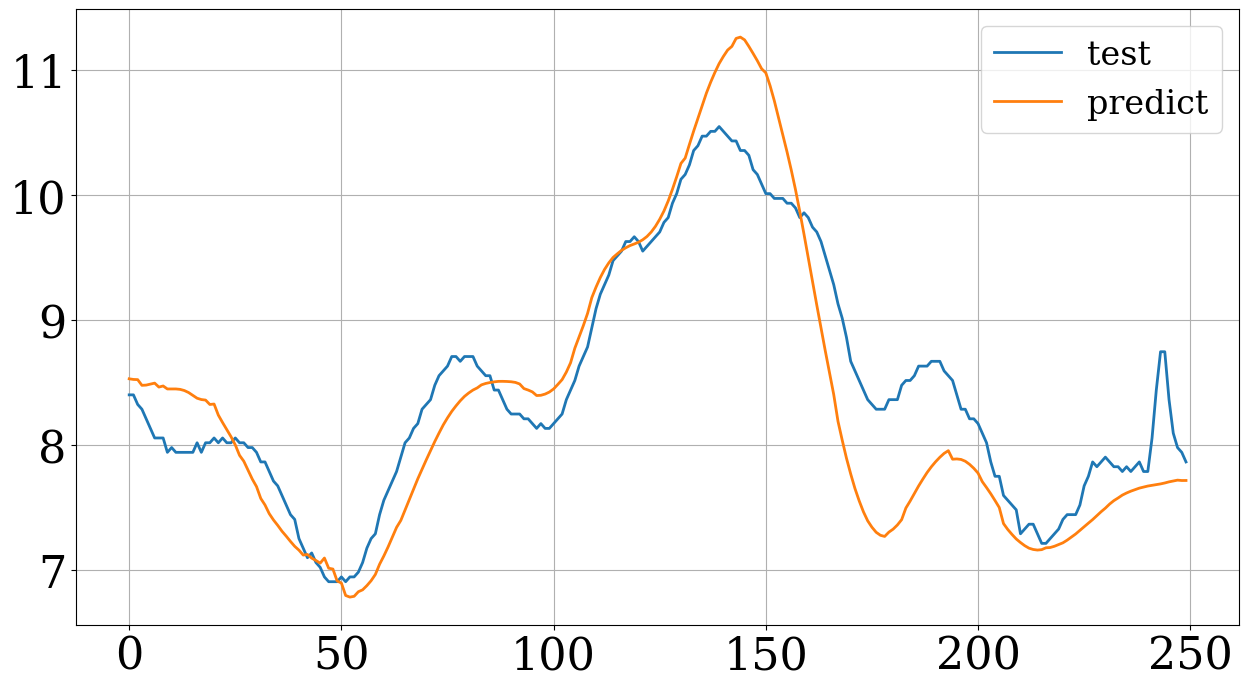

In [53]:
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(test_data.T[i], label='test')
        ax.plot(np.array(preds[i]).T, label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

In [98]:
preds = np.concatenate([np.array(preds[0]).reshape((len(preds[0]), 1)), 
                              np.array(preds[1]).reshape((len(preds[1]), 1)), 
                              np.array(preds[2]).reshape((len(preds[2]), 1))], axis=1)

### Multimodel based on local forecasting

In [77]:
train_dataset = {i: [] for i in range(train_data.shape[1])}

for i in range(train_data.shape[1]):
    for j in range(train_data.shape[0] - 2 * w_len):
        hankel_train = HankelMatrix(train_data[:2 * w_len + j + 1, i], w_len)
        distances = np.sum((hankel_train - hankel_train[-1]) ** 2, axis=1)
        nn = np.argsort(distances)
        nn = nn[nn != len(hankel_train) - 1]
        knn = nn[:k]
        nn_targets = hankel_train[knn + 1, -1]
        train_dataset[i].append(np.mean(nn_targets))

In [78]:
print(train_data[2 * w_len:, :].shape[0], len(train_dataset[0]))

5709 5709


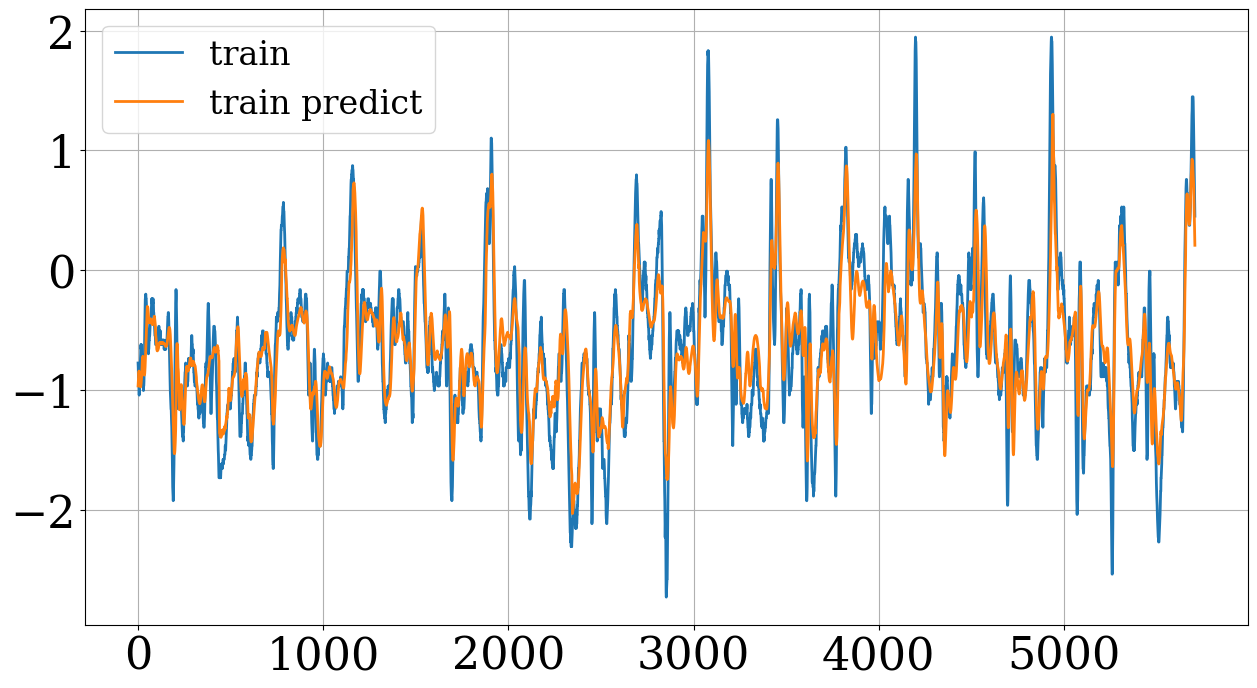

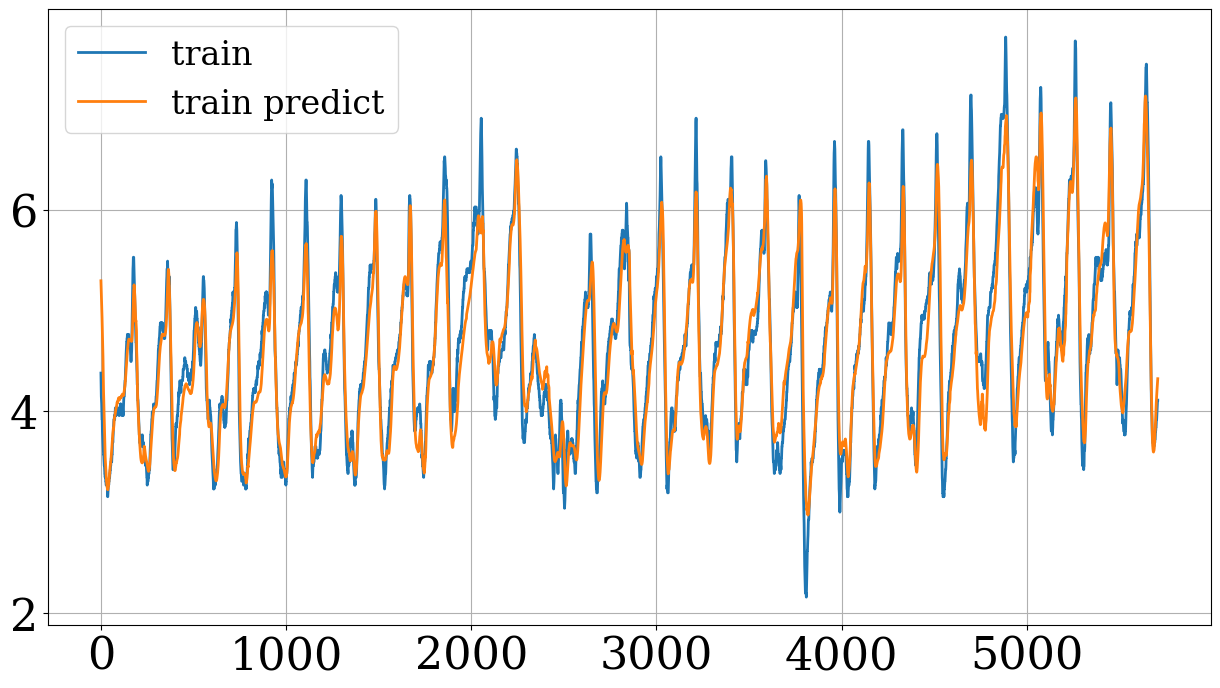

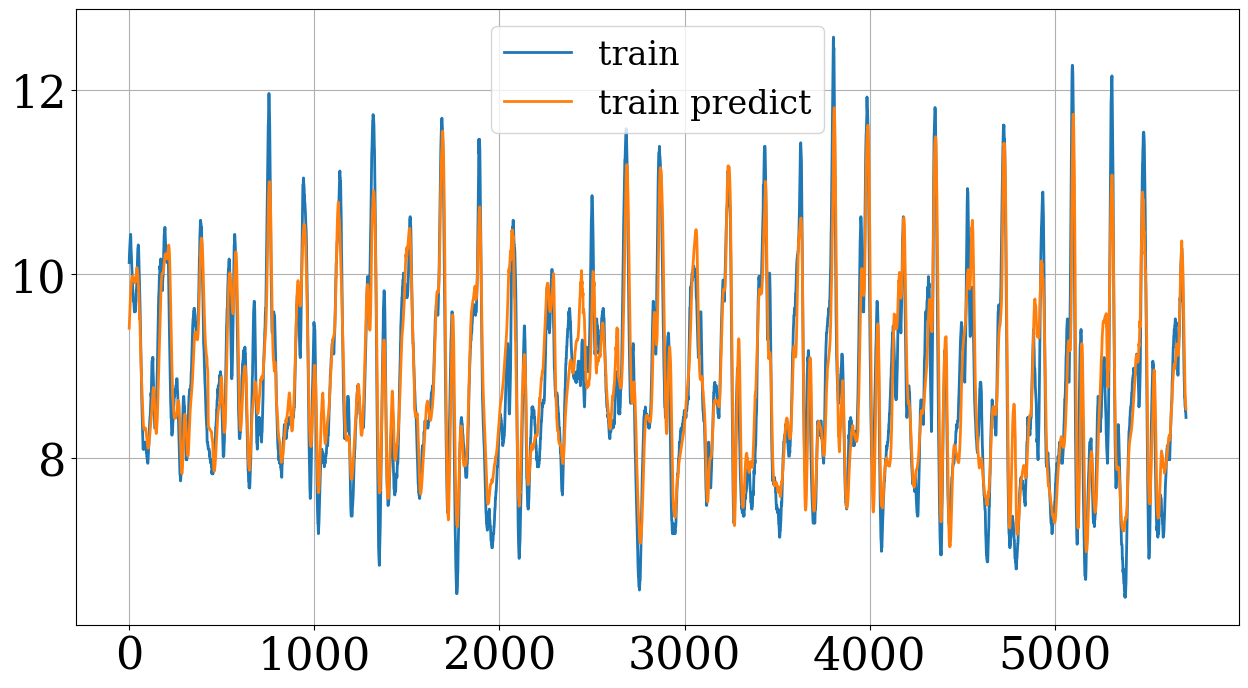

In [79]:
for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(train_data.T[i, 2 * w_len:], label='train')
        ax.plot(np.array(train_dataset[i]).T, label='train predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

#### Linear

In [80]:
tsp_X_local_train = tsp_X[w_len + 1:-1]

In [81]:
print(tsp_X_local_train.shape)

(5708, 6)


In [82]:
for i in range(3):
    train_dataset[i] = train_dataset[i][:-1]

In [83]:
train_numpy = np.concatenate([np.array(train_dataset[0]).reshape((len(train_dataset[0]), 1)), 
                              np.array(train_dataset[1]).reshape((len(train_dataset[1]), 1)), 
                              np.array(train_dataset[2]).reshape((len(train_dataset[2]), 1))], axis=1)

In [84]:
print(train_numpy.shape)

(5708, 3)


In [87]:
actual_train_ts = train_data[2 * w_len:-1, :]

In [88]:
X = np.concatenate([train_numpy, tsp_X_local_train], axis=1)
X_train, X_test, y_train,  y_test = train_test_split(X, actual_train_ts, test_size=0.2, random_state=42, shuffle=False)

In [89]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [90]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [91]:
y_pred_train = linear_reg.predict(X_train_transformed)
y_pred_test = linear_reg.predict(X_test_transformed)

In [95]:
# get MSE for every signal
train_mse_cov = np.mean((y_pred_train - y_train) ** 2, axis=0)
# get MAPE for every signal
train_mape_cov = np.mean(np.abs((y_pred_train - y_train) / y_train), axis=0)

print(f'MSE: {train_mse_cov}; Mean by signals = {np.mean(train_mse_cov):e}')
print(f'MAPE: {train_mape_cov}; Mean by signals = {np.mean(train_mape_cov):e}')

MSE: [0.07916478 0.05874647 0.16031595]; Mean by signals = 9.940907e-02
MAPE: [0.98359589 0.04083625 0.03563193]; Mean by signals = 3.533547e-01


In [96]:
# get MSE for every signal
test_mse_cov = np.mean((y_pred_test - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_cov = np.mean(np.abs((y_pred_test - y_test) / y_test), axis=0)

print(f'MSE: {test_mse_cov}; Mean by signals = {np.mean(test_mse_cov):e}')
print(f'MAPE: {test_mape_cov}; Mean by signals = {np.mean(test_mape_cov):e}')

MSE: [0.09795191 0.07937744 0.23044754]; Mean by signals = 1.359256e-01
MAPE: [1.0436764  0.04465698 0.0434497 ]; Mean by signals = 3.772610e-01


In [97]:
# get MSE for every signal
test_mse = np.mean((train_numpy[y_train.shape[0]:] - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape = np.mean(np.abs((train_numpy[y_train.shape[0]:] - y_test) / y_test), axis=0)

print(f'MSE: {test_mse}; Mean by signals = {np.mean(test_mse):e}')
print(f'MAPE: {test_mape}; Mean by signals = {np.mean(test_mape):e}')

MSE: [0.10851044 0.08789839 0.24553677]; Mean by signals = 1.473152e-01
MAPE: [0.90667065 0.04812459 0.04506511]; Mean by signals = 3.332868e-01


#### Используем мульти модель на тесте

In [106]:
train_plus_preds = np.concatenate([train_data, preds], axis=0)[train_data.shape[0] - w_len:]

In [109]:
print(train_plus_preds.shape)
k = 1

(850, 3)


In [110]:
cov_test = np.array([train_plus_preds.T[:, i * k:i * k + w_len] for i in range(((train_plus_preds.shape[0] - w_len + 1) // k + 1) - 1)])

In [111]:
print(cov_test.shape)

(251, 3, 600)


In [112]:
est_test_cov = cov.transform(cov_test)

In [115]:
tangent_space = TangentSpace()
tsp_cov_test = tangent_space.fit_transform(est_test_cov)[:-1]

In [116]:
print(tsp_cov_test.shape)

(250, 6)


In [117]:
test = np.concatenate([preds, tsp_cov_test], axis=1)

In [118]:
test_scaled = scaler.transform(test)
test_pred = linear_reg.predict(test_scaled)

In [119]:
# get MSE for every signal
test_mse = np.mean((test_pred - test_data) ** 2, axis=0)
# get MAPE for every signal
train_mape = np.mean(np.abs((test_pred - test_data) / test_data), axis=0)

print(f'MSE: {test_mse}; Mean by signals = {np.mean(test_mse):e}')
print(f'MAPE: {train_mape}; Mean by signals = {np.mean(train_mape):e}')

MSE: [0.29475345 0.17361614 0.28594292]; Mean by signals = 2.514375e-01
MAPE: [1.8937509  0.06621068 0.05101775]; Mean by signals = 6.703264e-01


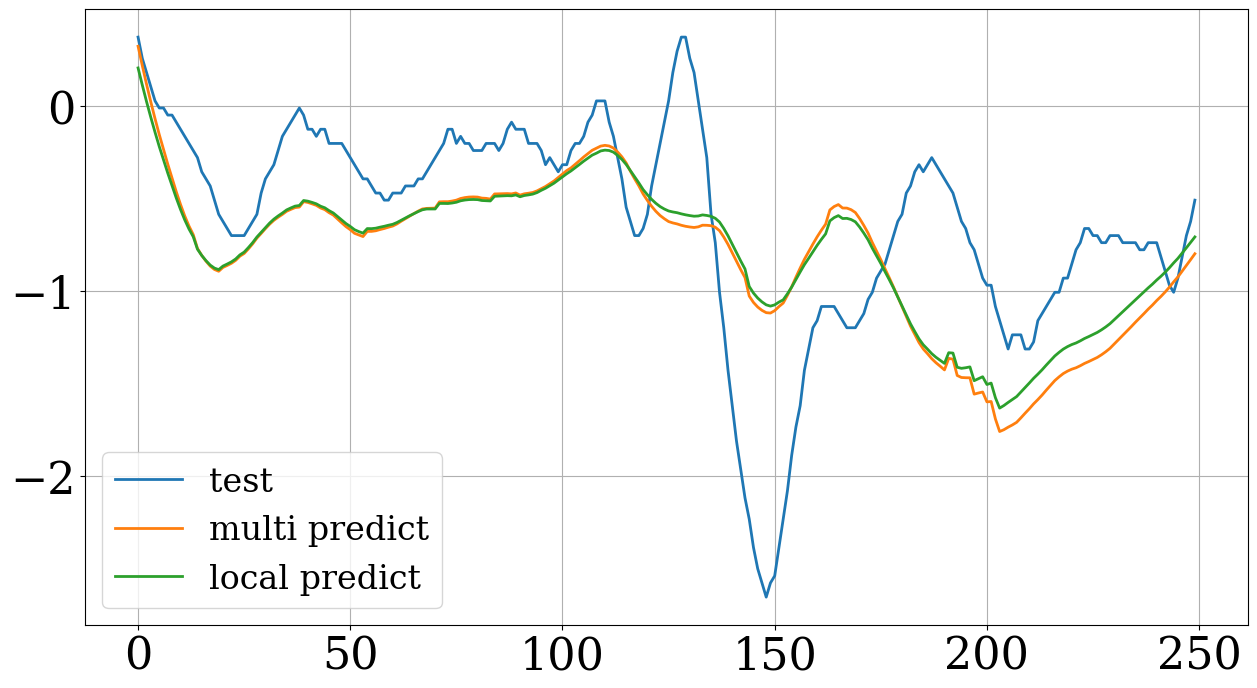

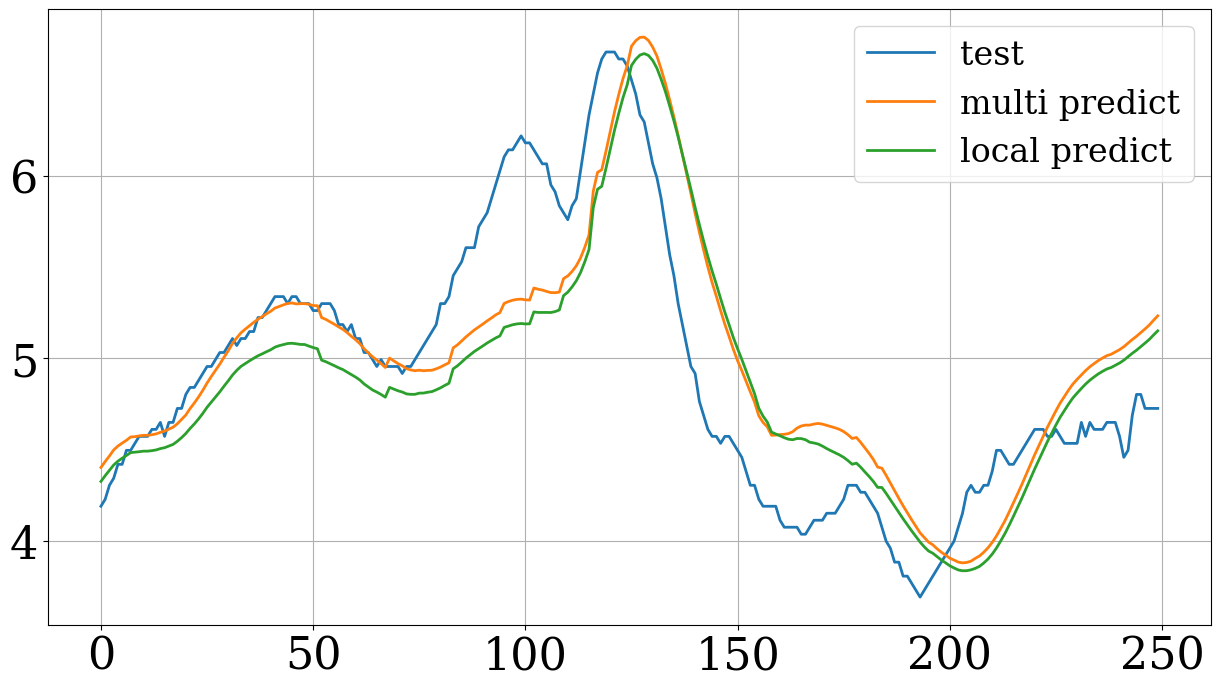

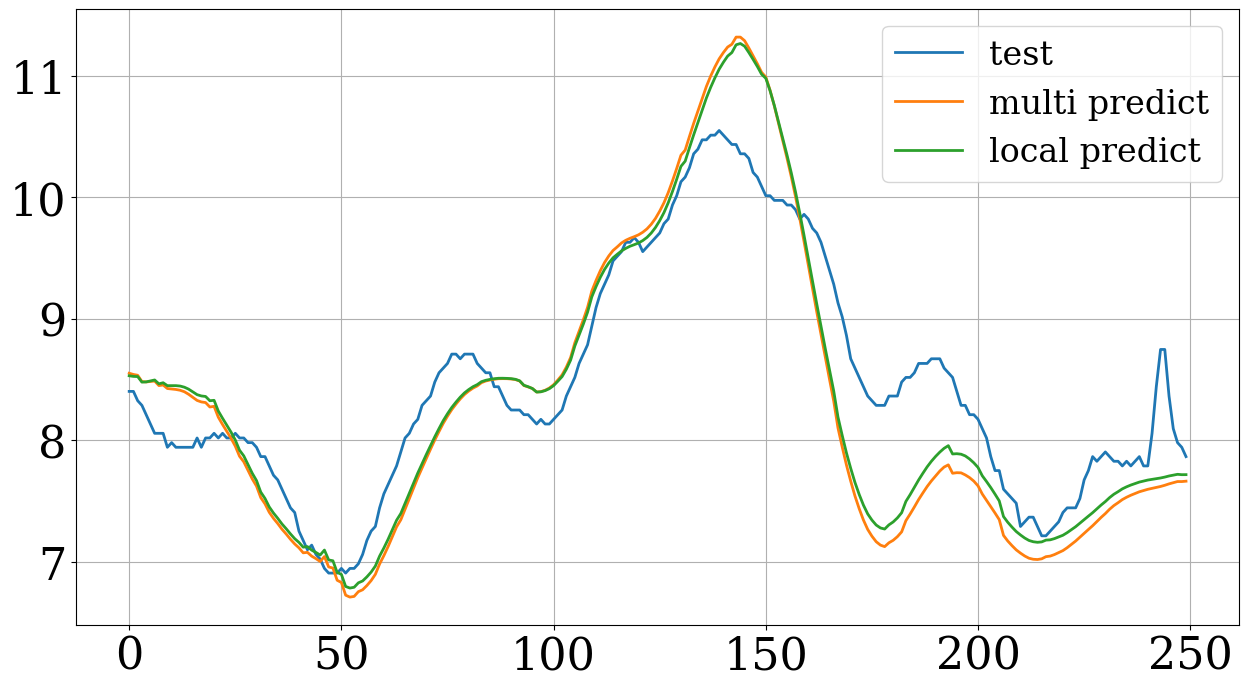

In [121]:
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(test_data.T[i], label='test')
        ax.plot(test_pred.T[i], label='multi predict')
        ax.plot(preds.T[i], label='local predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

# tSSA

In [108]:
# aka L parameter
ssa_window_size = 600

cpd_ranks = np.arange(5, 30 + 1, 5)
forecast_results = {key: {"mse": None, "mape": None} for key in cpd_ranks}

# parameter for detereministic behaviour of tSSA
random_state = 42

In [109]:
models_cpd_rank = []

In [ ]:
for cpd_rank in cpd_ranks:
    print(f"CP rank = {cpd_rank}")

    t_ssa_obj = t_SSA(ssa_window_size, train_data.T, cpd_rank)

    # make svd for common matrix, extract factors and singular values
    t_ssa_obj.decompose_tt(random_state=random_state)
    print(f"CPD-error = {t_ssa_obj.cpd_err_rel}")

    models_cpd_rank.append(t_ssa_obj)

    t_ssa_obj.remove_last_predictions()

    # get prediction for cuurent number of factors left
    forecast_tssa = np.empty(test_data.shape)

    for i in range(test_data.shape[0]):
        forecast_tssa[i] = np.array(t_ssa_obj.predict_next())

    # get MSE for every signal
    signals_mse_tssa = np.mean((forecast_tssa - test_data) ** 2, axis=0)
    # get MAPE for every signal
    signals_mape_tssa = np.mean(np.abs((forecast_tssa - test_data) / test_data), axis=0)

    forecast_results[cpd_rank]["mse"] = signals_mse_tssa
    forecast_results[cpd_rank]["mape"] = signals_mape_tssa

    print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
    print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

CP rank = 5
CPD-error = 0.10179471137561173
MSE: [0.95419051 0.32097639 0.26970563]; Mean by signals = 5.149575e-01
MAPE: [1.98551571 0.09997854 0.05027947]; Mean by signals = 7.119246e-01
CP rank = 10
CPD-error = 0.09142701489103147
MSE: [0.8571548  0.20539751 0.36045169]; Mean by signals = 4.743347e-01
MAPE: [2.8837029  0.07844085 0.05867111]; Mean by signals = 1.006938e+00
CP rank = 15
CPD-error = 0.08117775089878532
MSE: [0.33867119 0.11536932 0.28394647]; Mean by signals = 2.459957e-01
MAPE: [1.80132975 0.06096833 0.04640271]; Mean by signals = 6.362336e-01
CP rank = 20
CPD-error = 0.0735574904648639
MSE: [0.42237028 0.78915252 0.62391168]; Mean by signals = 6.118115e-01
MAPE: [2.33028701 0.15166193 0.0735341 ]; Mean by signals = 8.518277e-01
CP rank = 25
CPD-error = 0.06681082953041223
MSE: [0.48254161 0.27608285 0.42787364]; Mean by signals = 3.954994e-01
MAPE: [1.83042388 0.08827622 0.06397479]; Mean by signals = 6.608916e-01
CP rank = 30
CPD-error = 0.058813496572299895
MSE: [

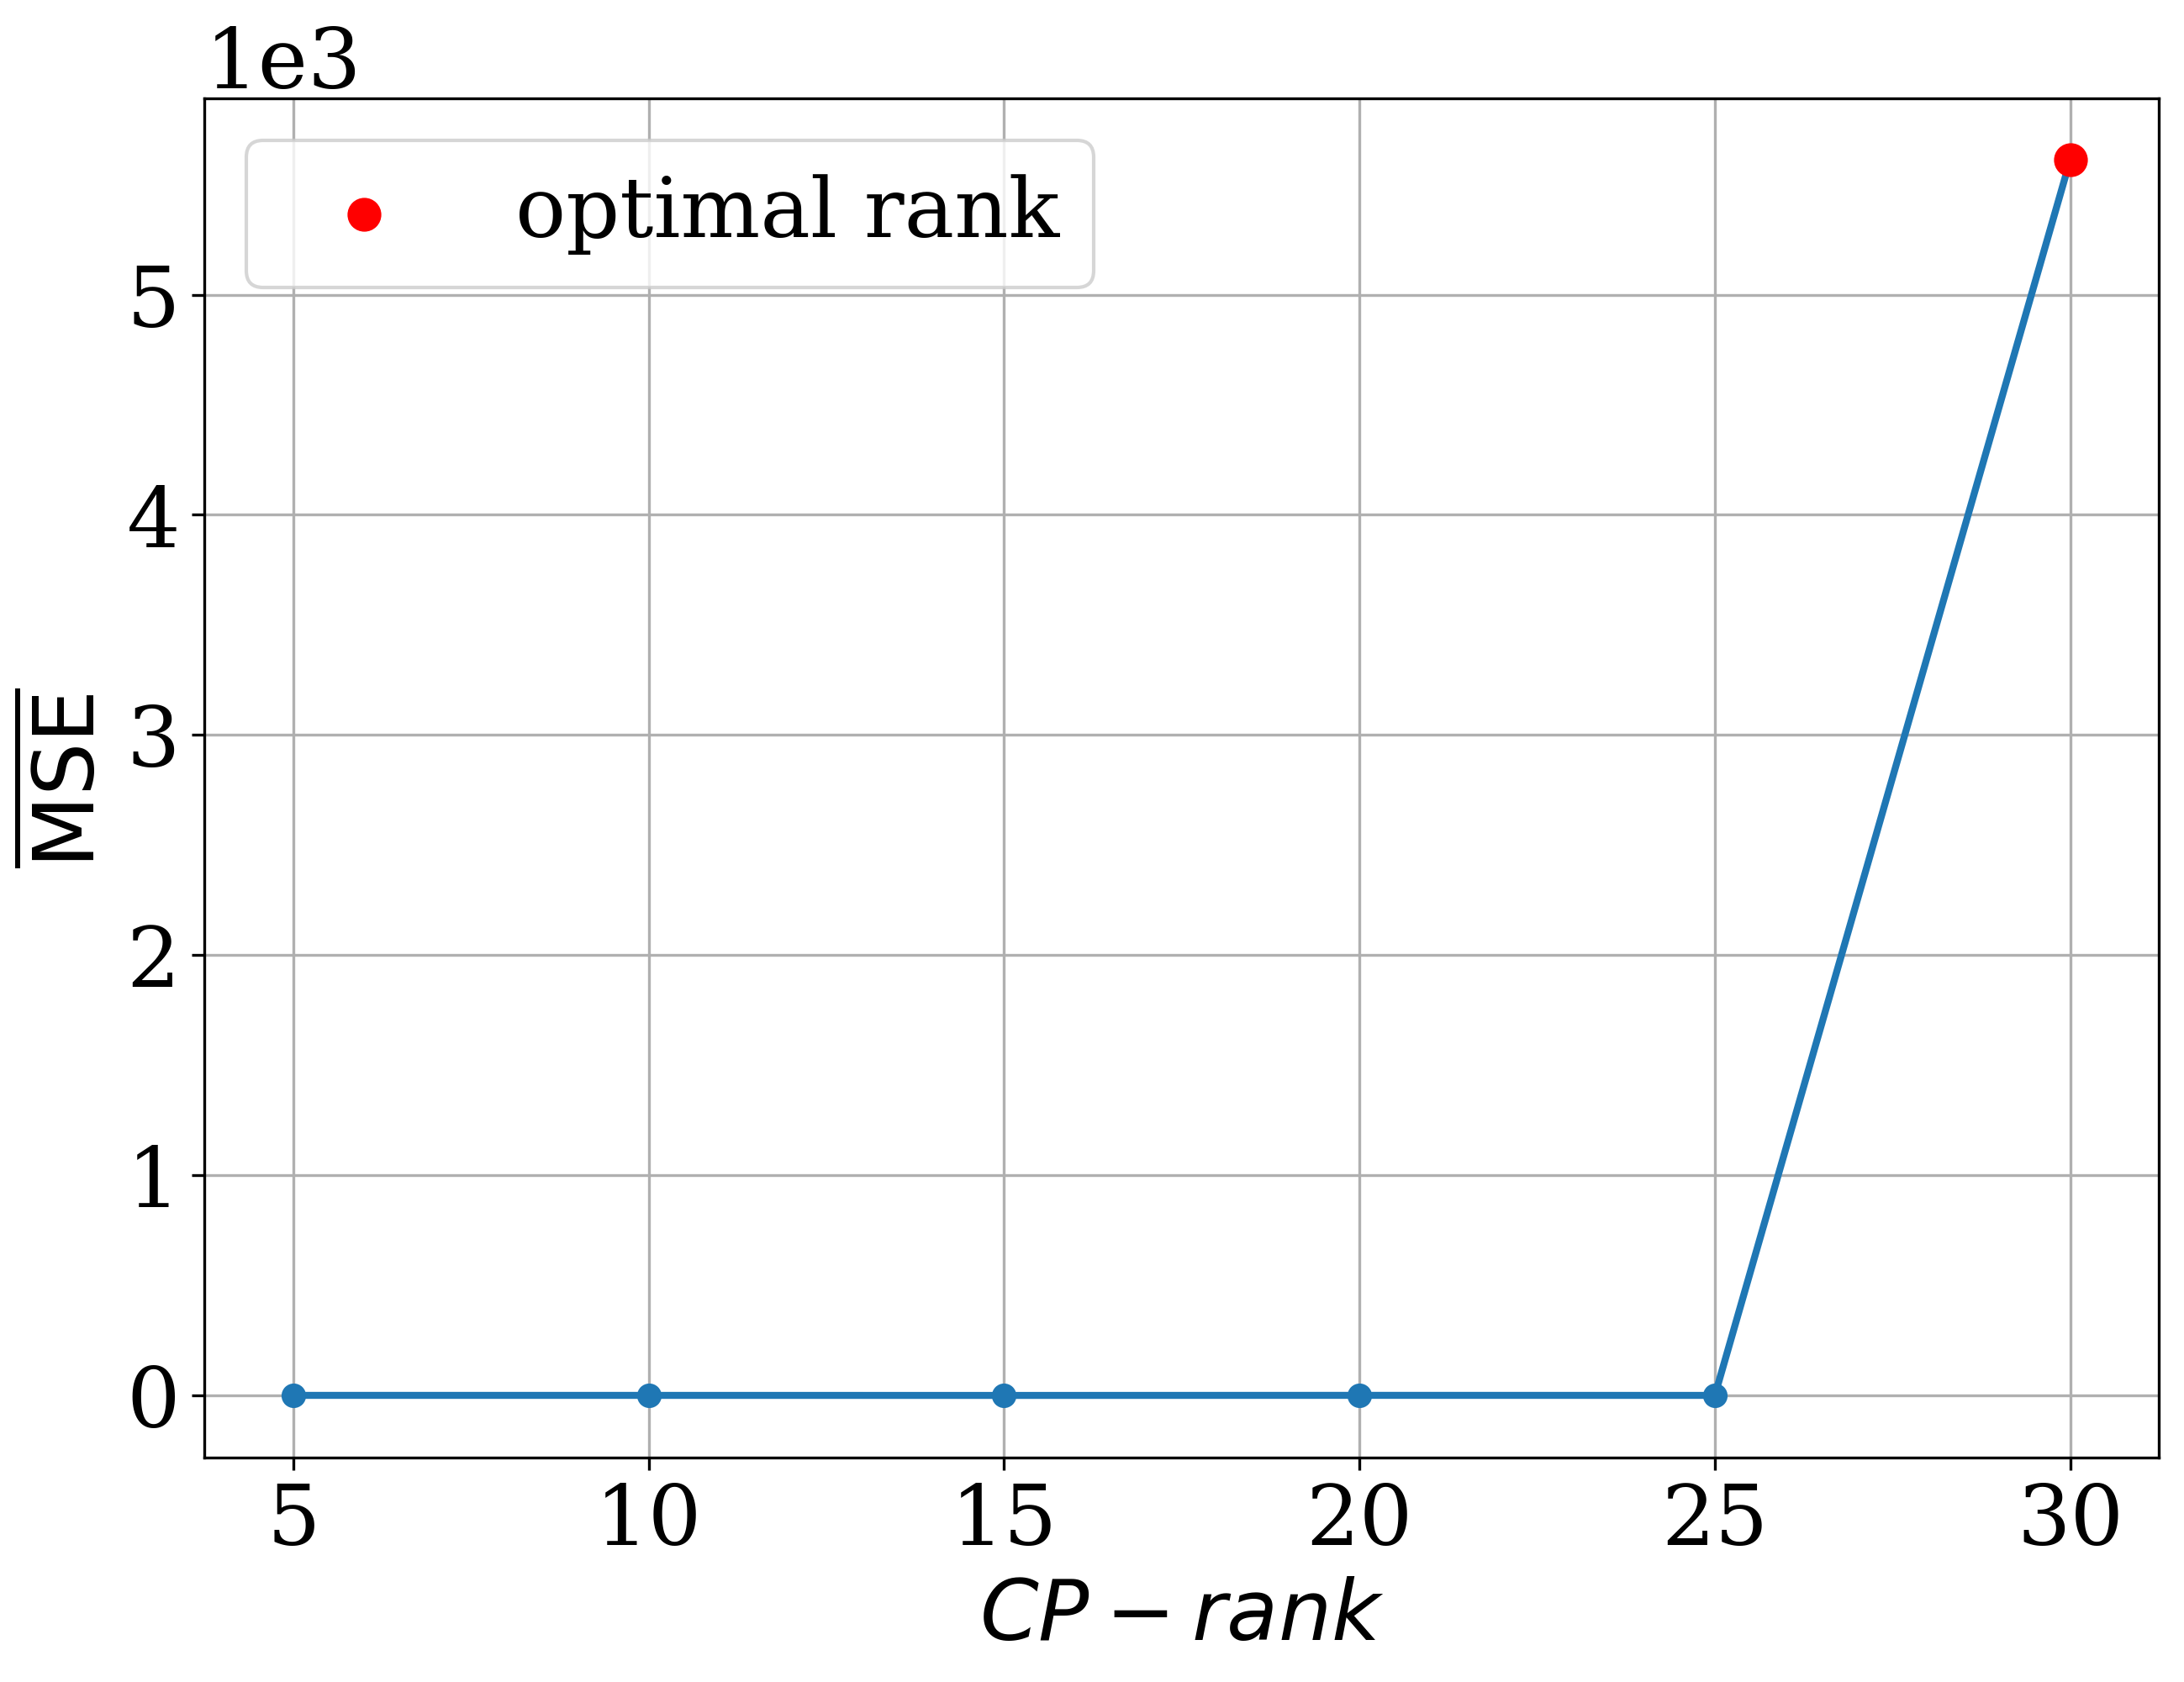

In [ ]:
# plot mean MSE
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(10, 7))

    mean_mses = []
    for key, item in forecast_results.items():
        mean_mses.append(item["mse"].mean())

    ax.plot(forecast_results.keys(), mean_mses, marker=".")
    ax.scatter([30], [mean_mses[5]], marker=".", s=300, c="red", label="optimal rank", zorder=10)

    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MSE}} $")
    ax.set_xlabel('$CP-rank$')

    ax.set_xticks(list(forecast_results.keys()))
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

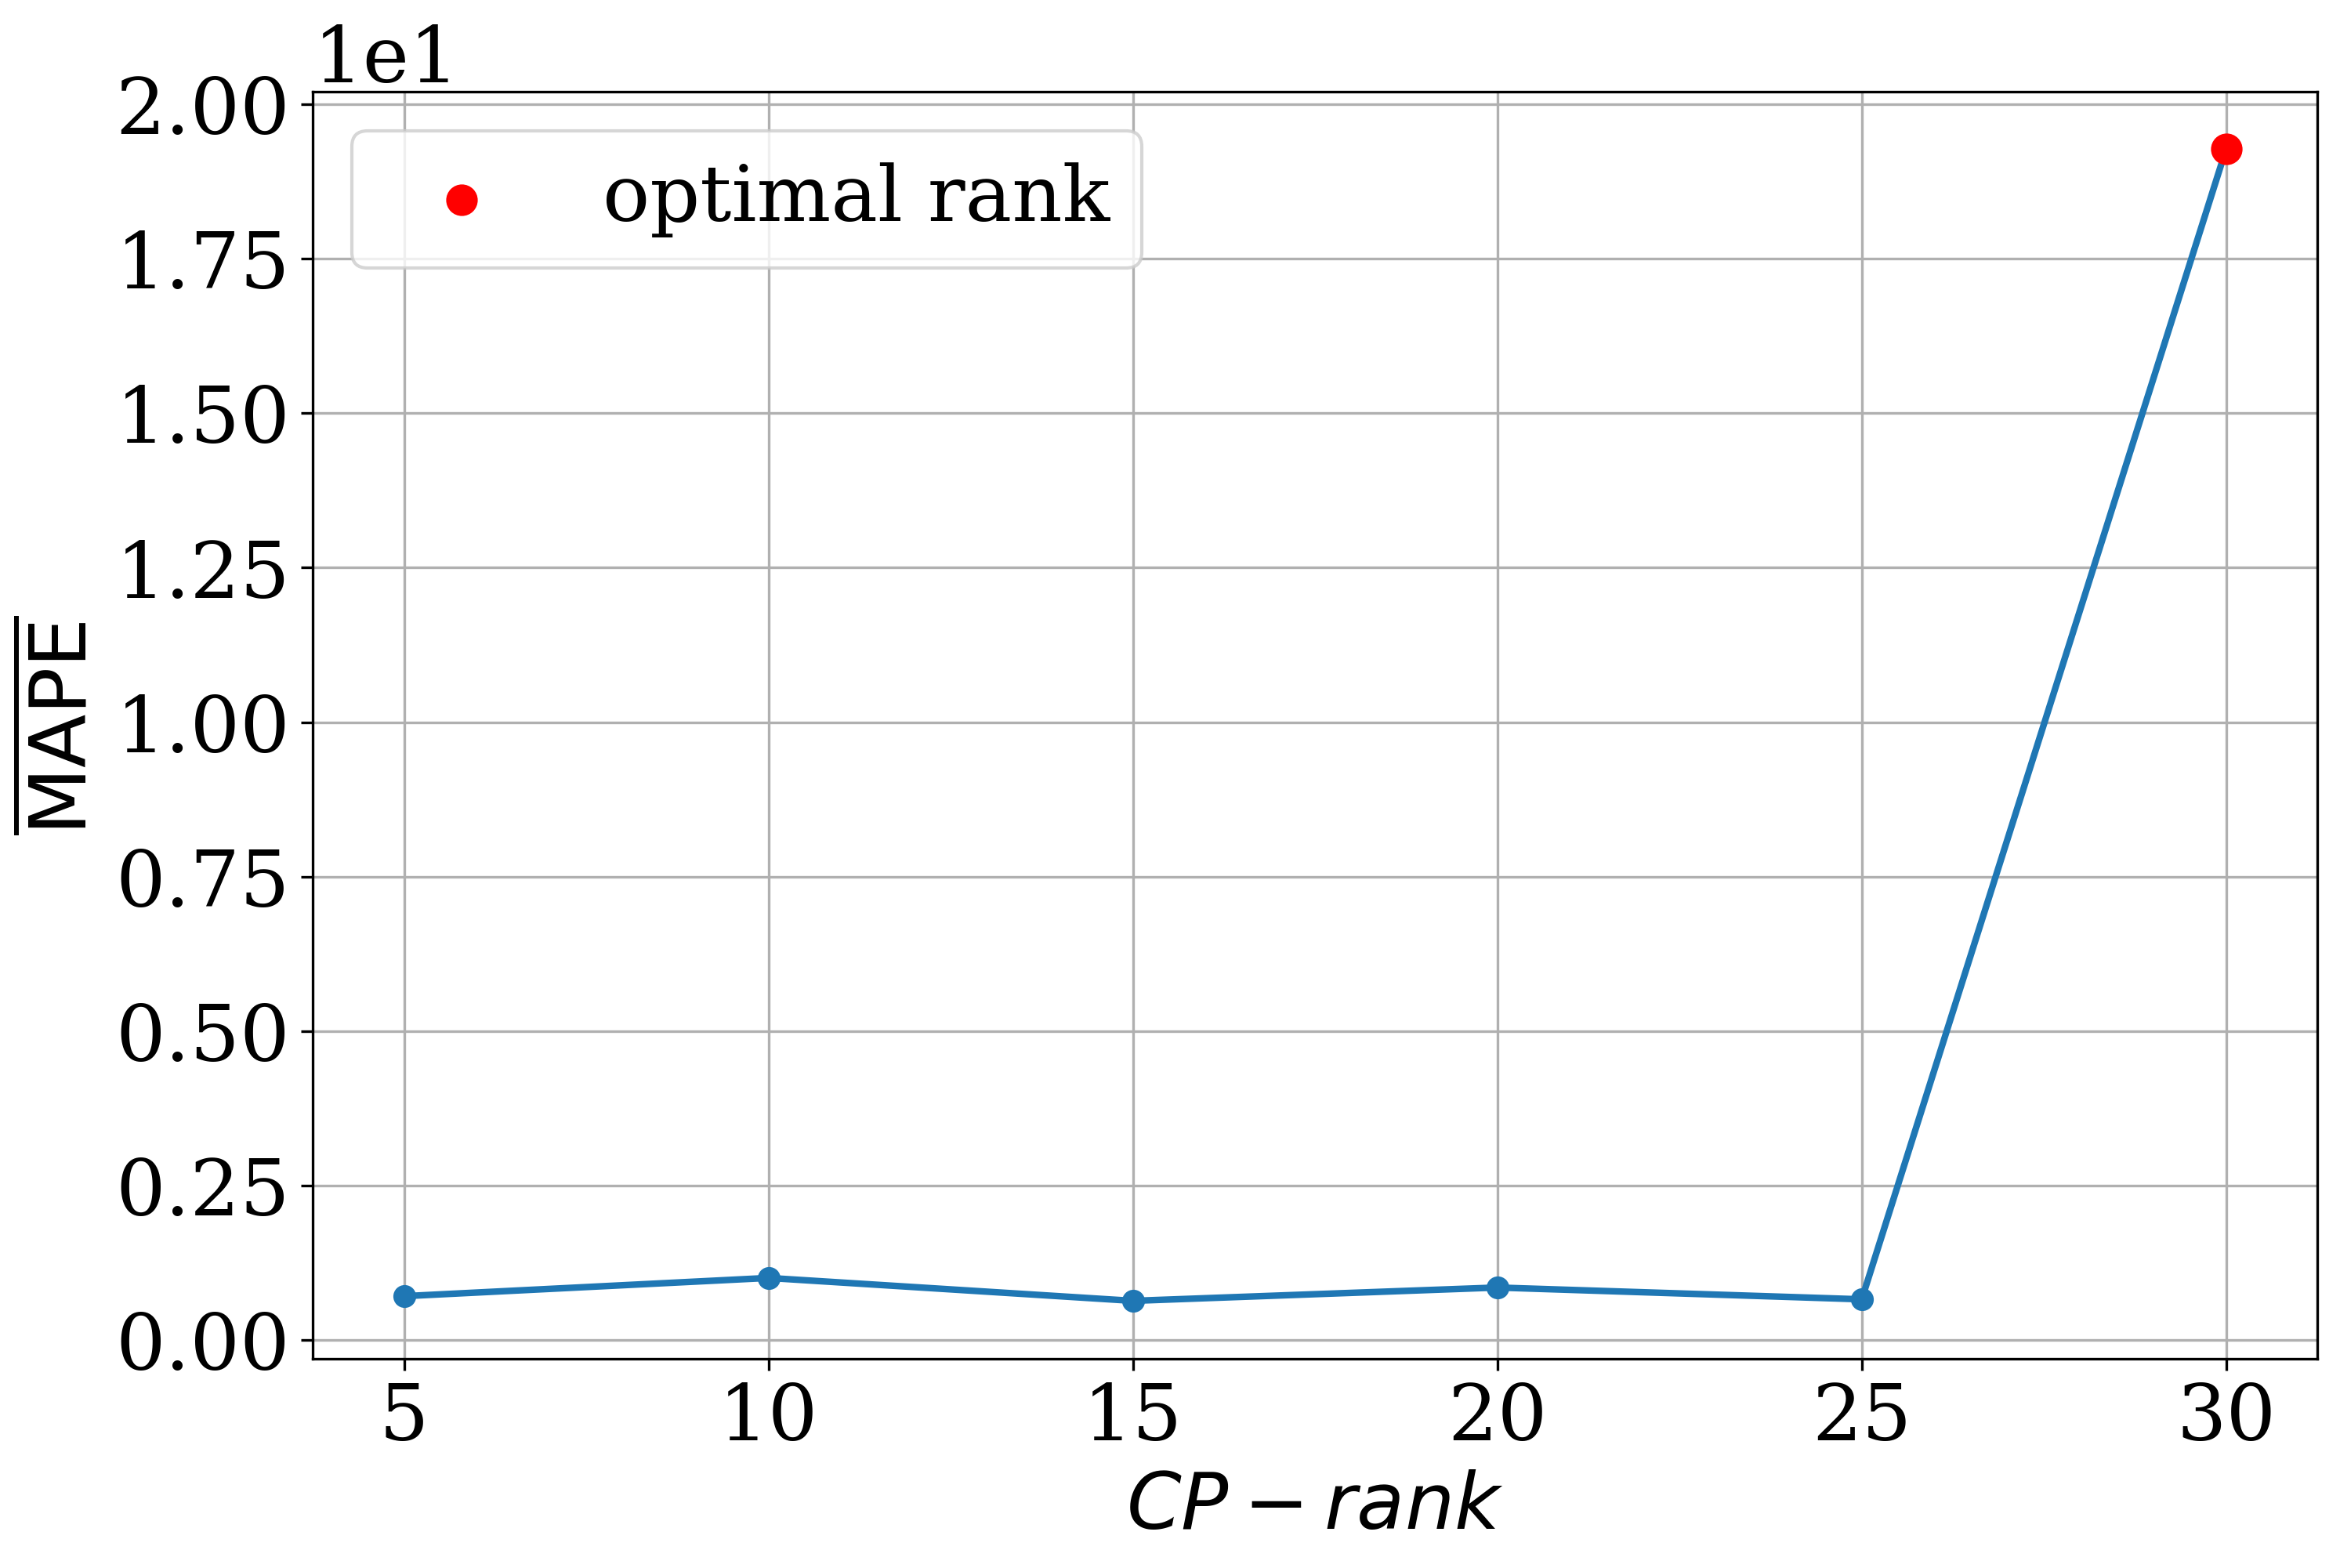

In [ ]:
# plot mean MAPE
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(11, 7))

    mean_mapes = []
    for key, item in forecast_results.items():
        mean_mapes.append(item["mape"].mean())

    ax.plot(forecast_results.keys(), mean_mapes, marker=".")
    ax.scatter([30], [mean_mapes[5]], marker=".", s=300, c="red", label="optimal rank", zorder=10)

    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MAPE}} $")
    ax.set_xlabel('$CP-rank$')

    ax.set_xticks(list(forecast_results.keys()))
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

Как видим, оптимальный ранг равен 15.

In [110]:
tssa_best = models_cpd_rank[2]
forecast_tssa = np.empty(test_data.shape)
tssa_best.remove_last_predictions()
for i in range(test_data.shape[0]):
    forecast_tssa[i] = np.array(tssa_best.predict_next())

IndexError: list index out of range

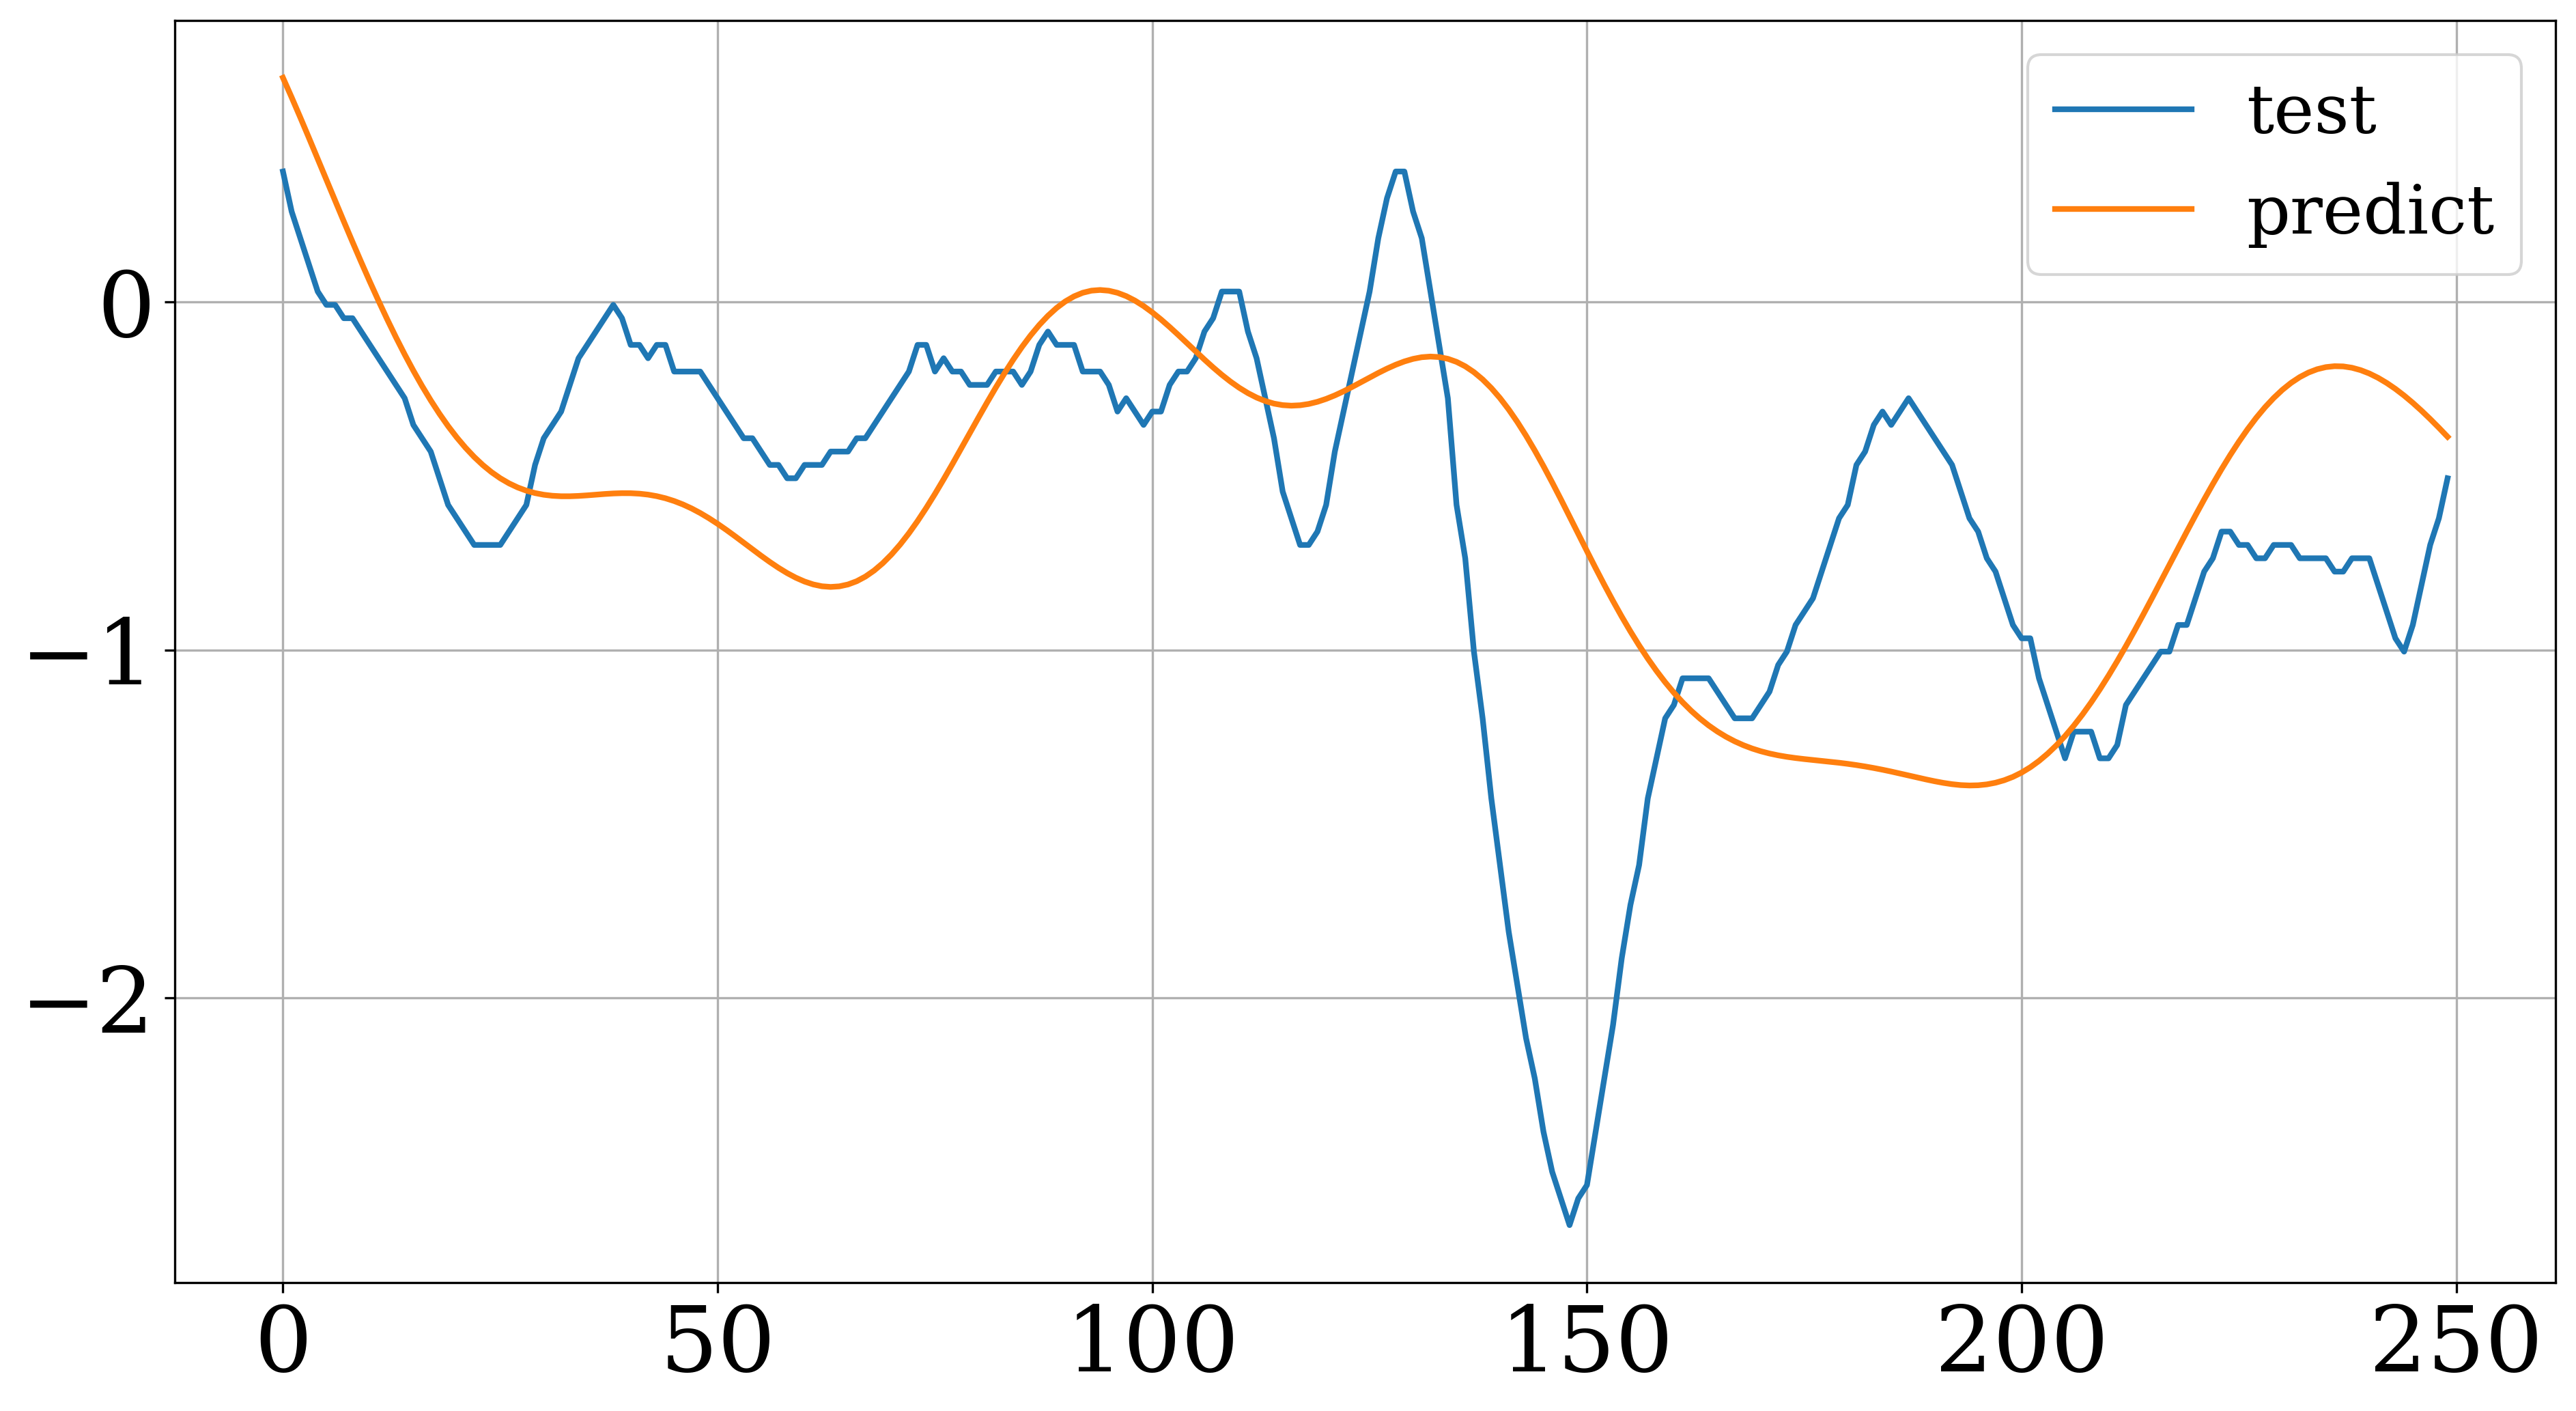

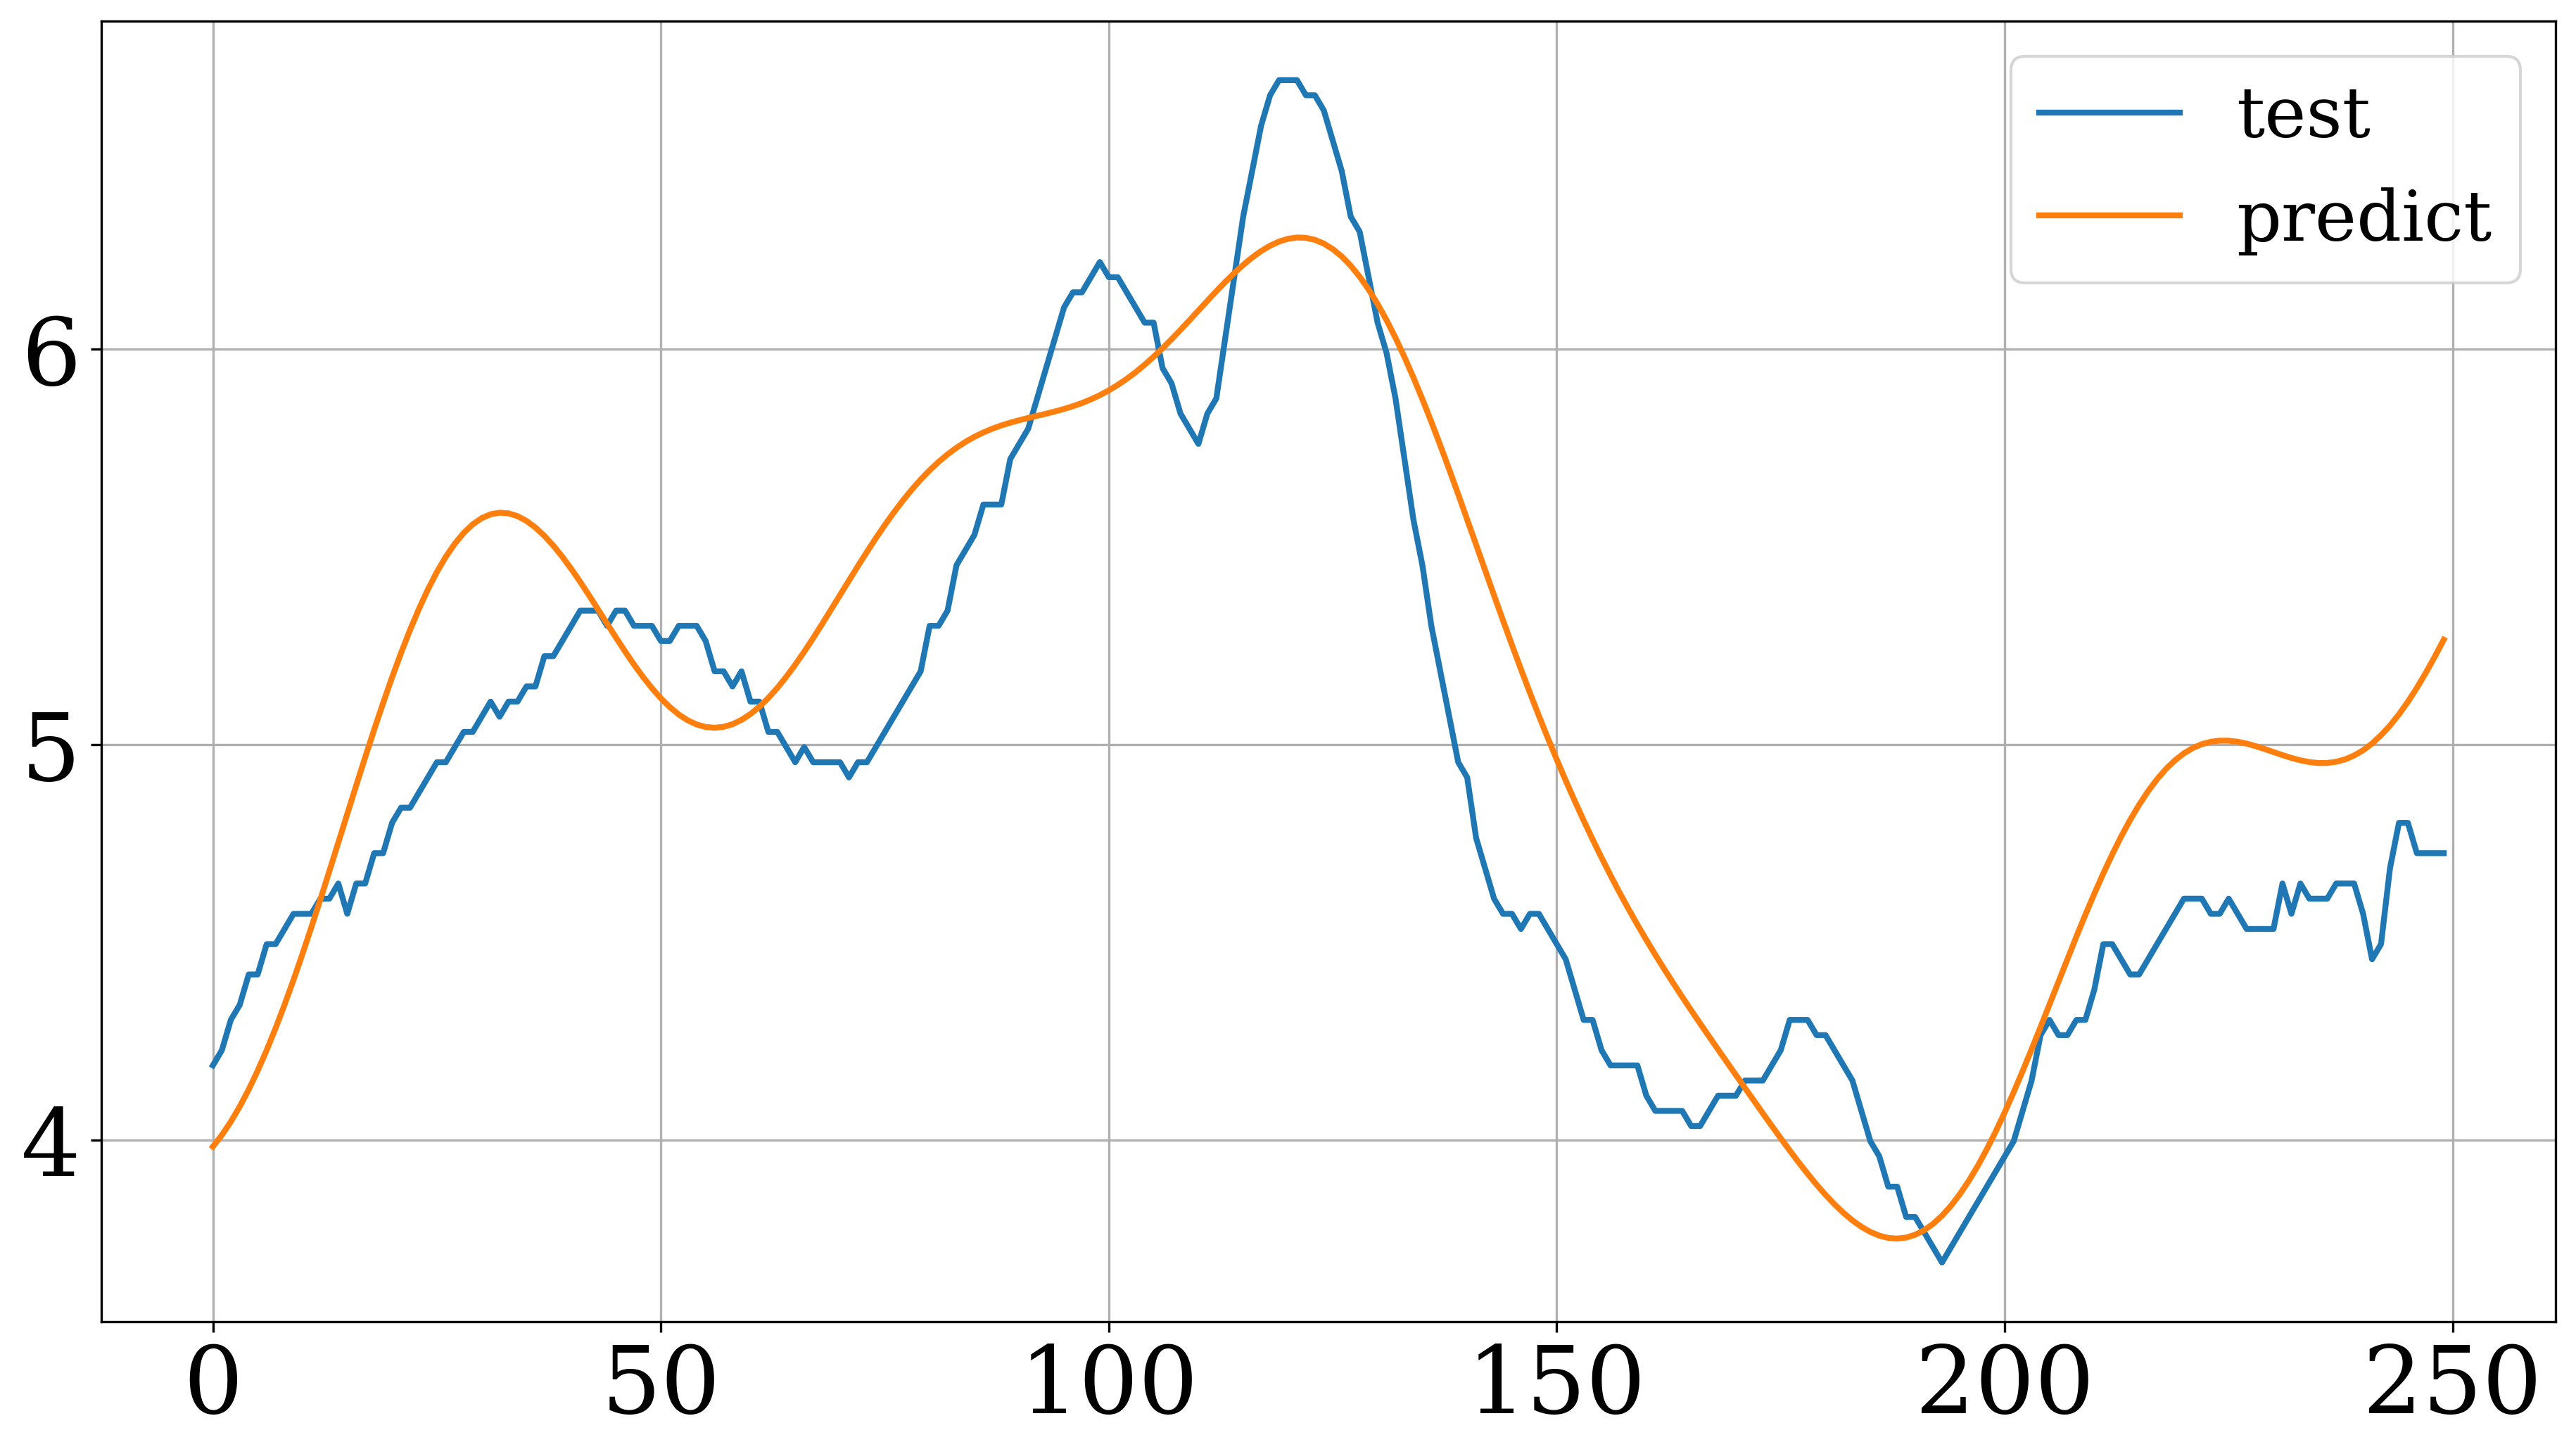

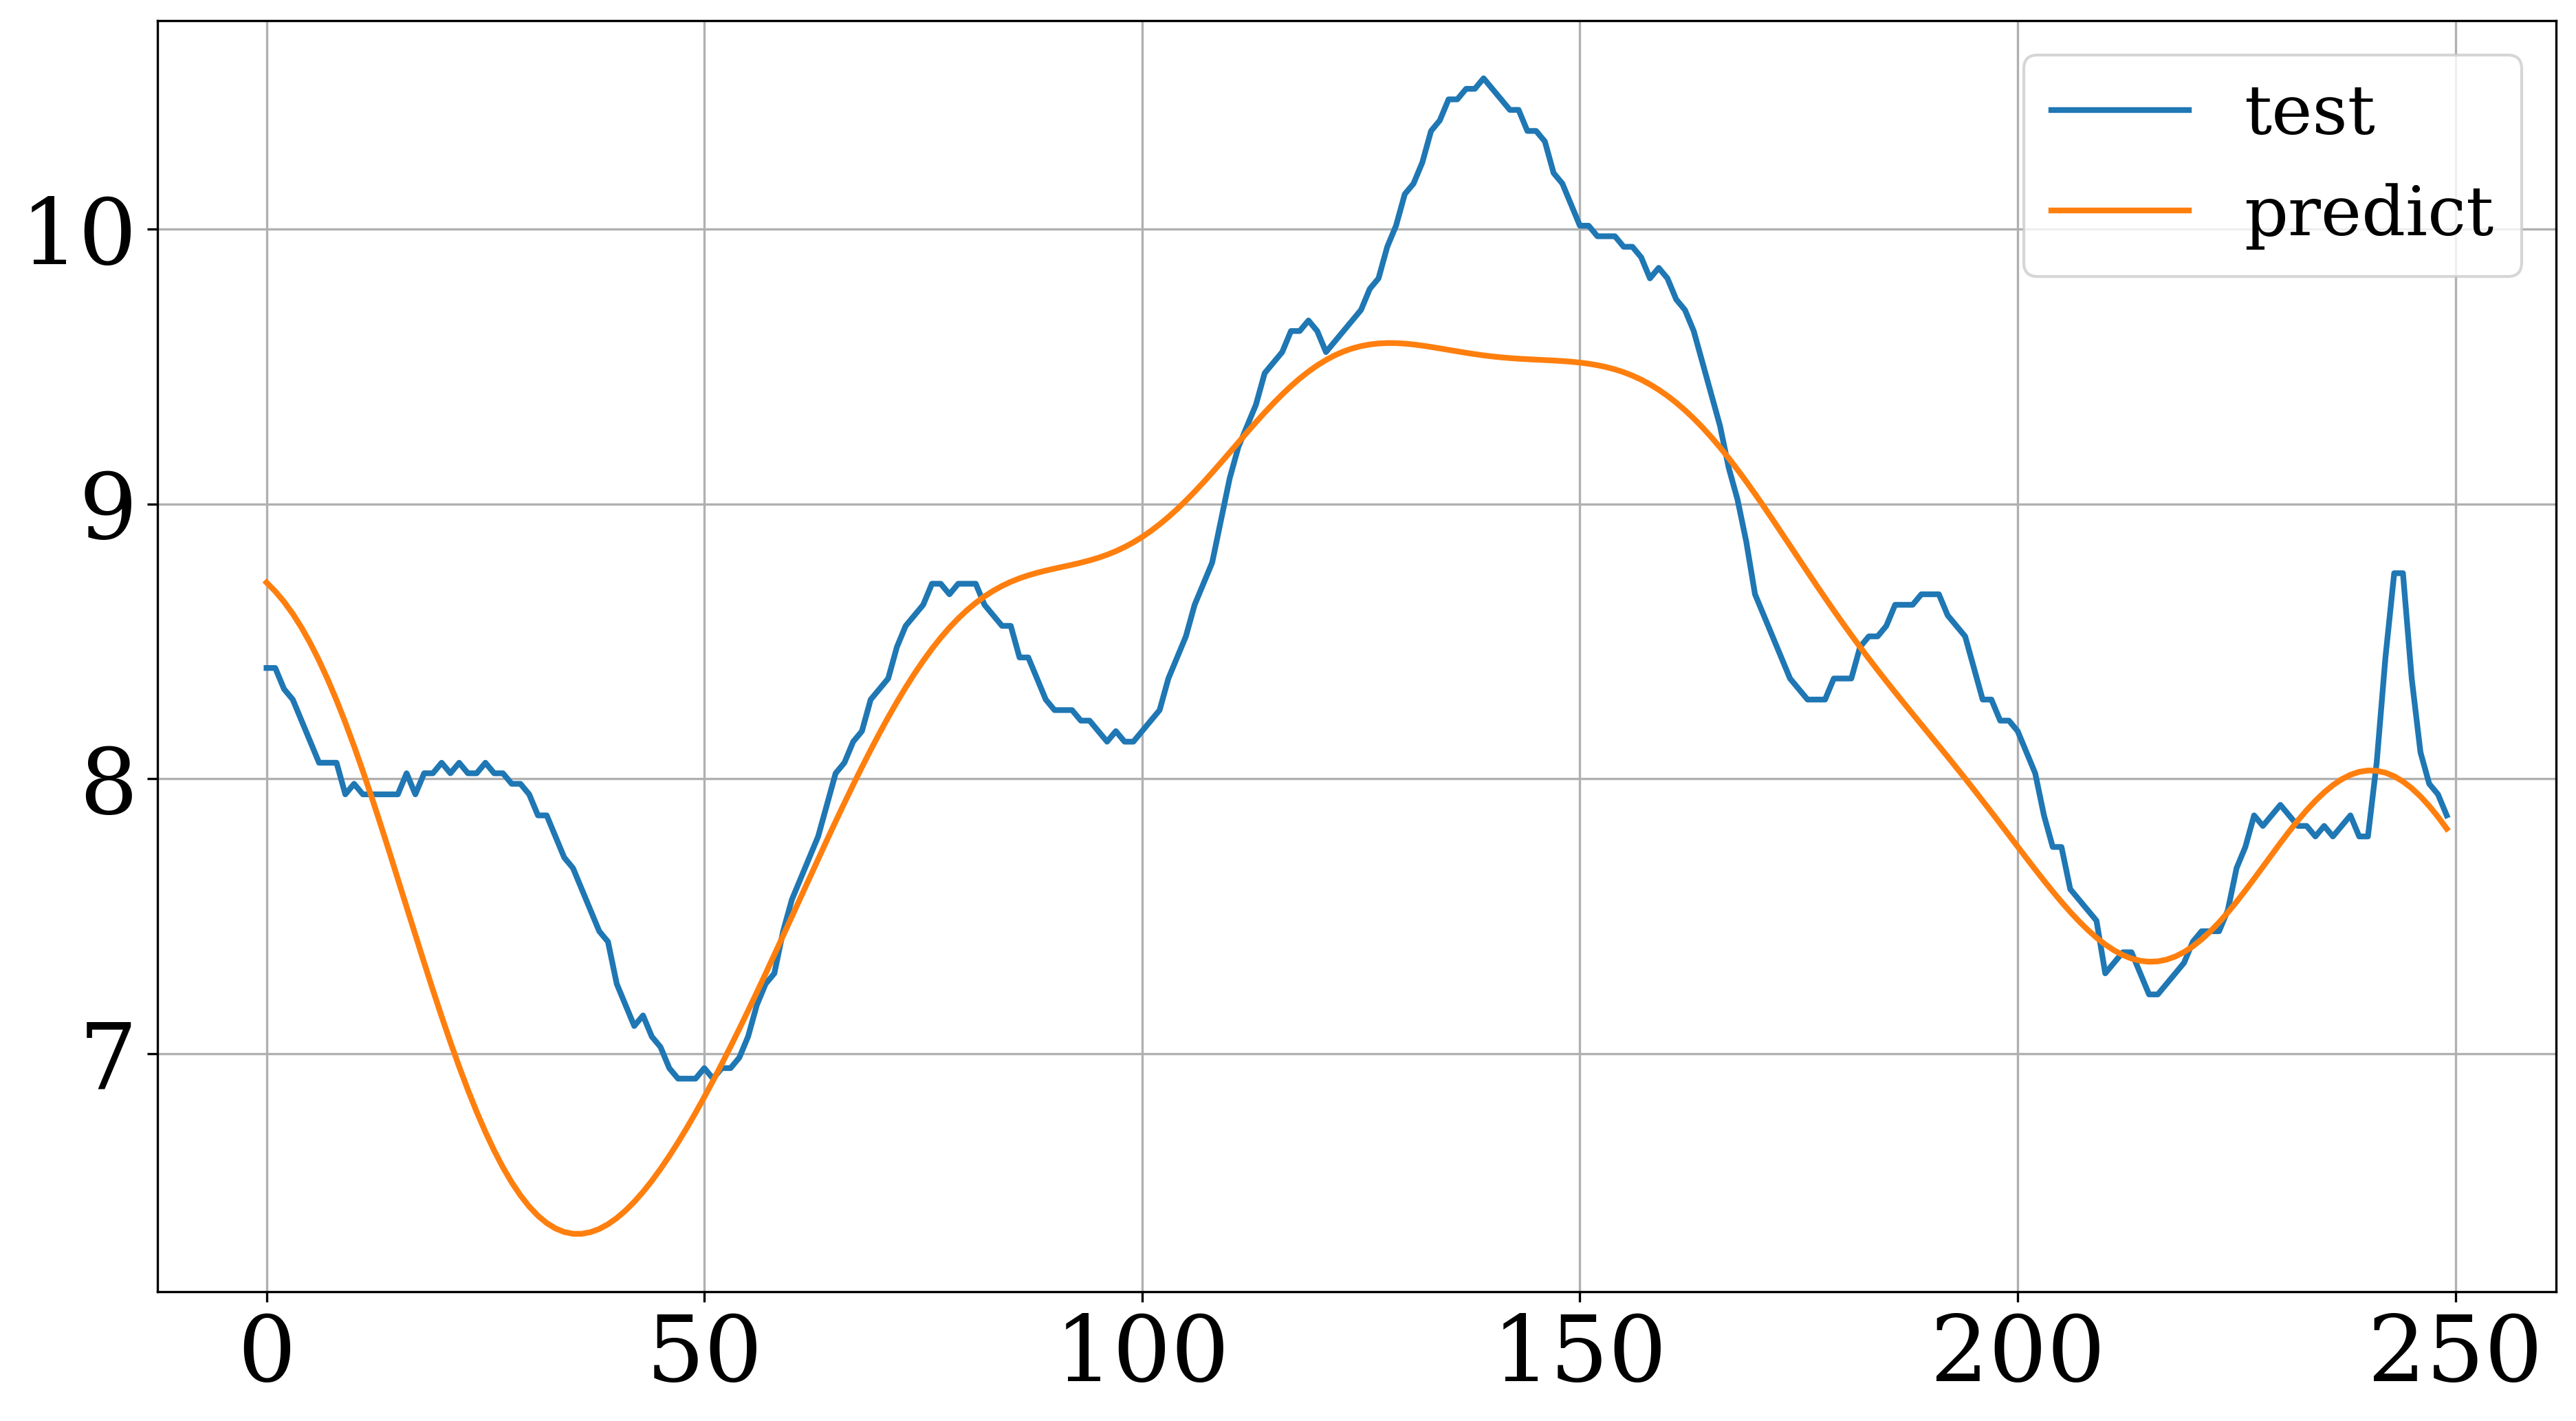

In [ ]:
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(test_data.T[i], label='test')
        ax.plot(forecast_tssa.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

# Предсказание на train только с помощью tSSA

Дла начала еще раз выполним tSSA с определенным заранее рангом канонического разложения.

In [111]:
optimal_rank = 15

t_ssa = t_SSA(ssa_window_size, train_data.T, optimal_rank)
t_ssa.decompose_tt(random_state=random_state)

Теперь получим предсказания tSSA на обучающей выборке с помощью реализованной функции `non_sequential_pred`:

In [112]:
delay_vectors = np.array([train_ts.to_numpy().T[:, i * k:i * k + (w_len - 1)] for i in range(((train_ts.shape[0] - (w_len - 1) + 1) // k + 1) - 1)])

In [113]:
print(delay_vectors.shape)

(6311, 3, 599)


Будем использовать наиболее простой в реализации подход:

In [114]:
delay_vectors_1 = delay_vectors[1:]

In [115]:
print(delay_vectors_1.shape)

(6310, 3, 599)


In [116]:
predicted_ts = []

In [117]:
for delay in delay_vectors_1:
    preds = t_ssa.non_sequential_pred(delay)
    predicted_ts.append(preds)

In [118]:
predicted_ts = np.array(predicted_ts[:-1]) # убираем последний, т.к. предсказание выходит за рамки обучающей выборки
print(predicted_ts.shape)

(6309, 3)


In [119]:
actual_train_ts = train_ts.iloc[w_len:, :].to_numpy()

In [120]:
print(actual_train_ts.shape)

(6309, 3)


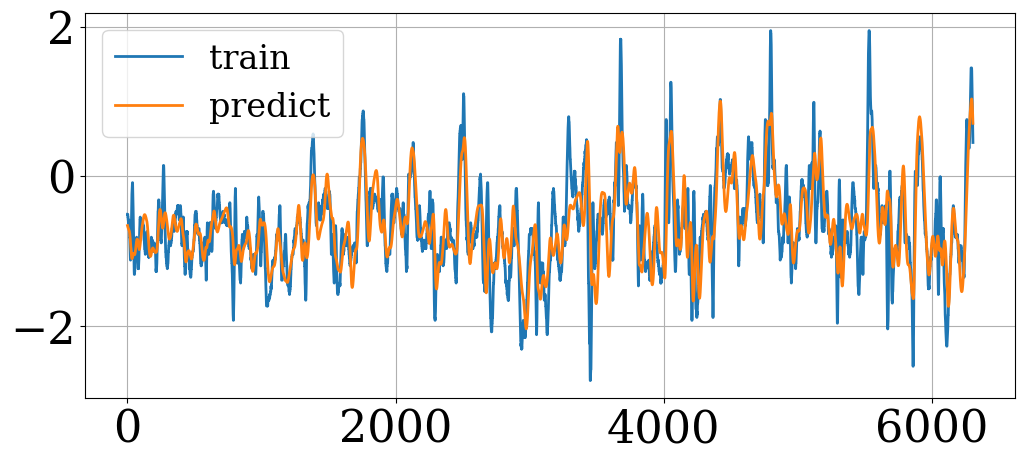

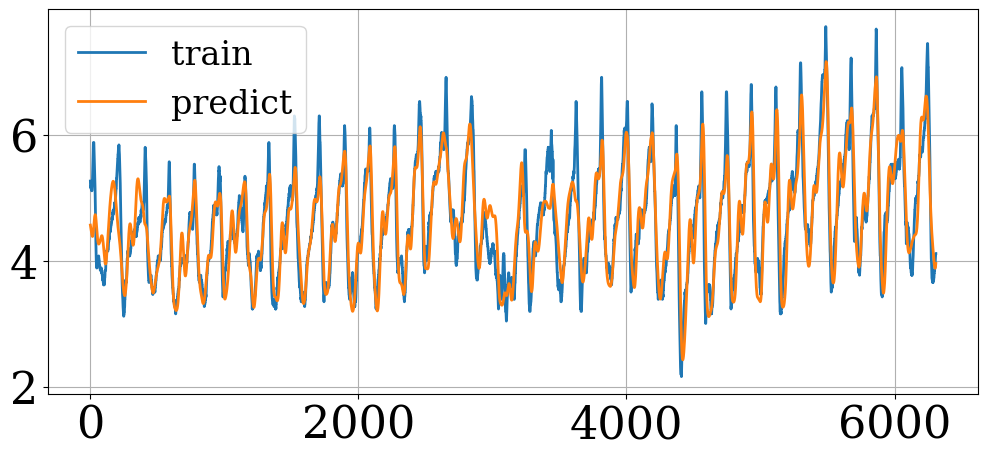

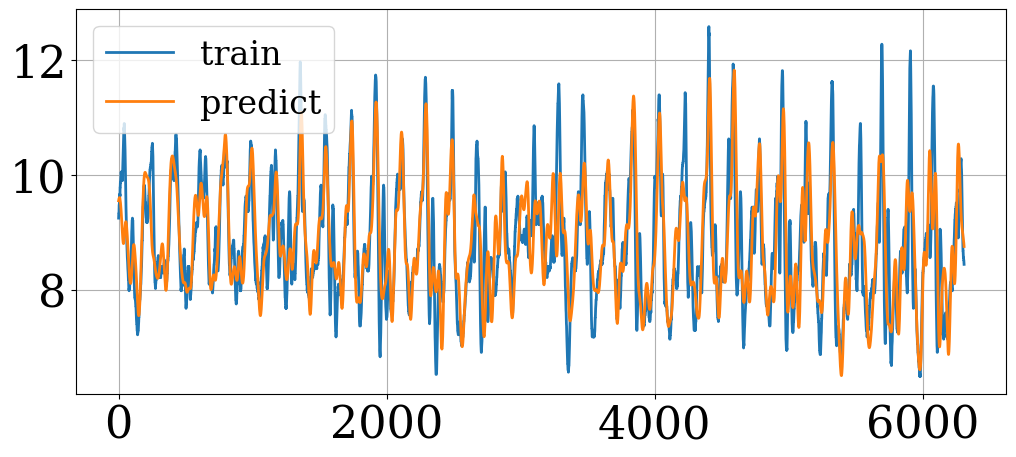

In [121]:
for i in range(actual_train_ts.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(actual_train_ts.T[i], label='train')
        ax.plot(predicted_ts.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

In [122]:
# get MSE for every signal
signals_mse_tssa = np.mean((predicted_ts - actual_train_ts) ** 2, axis=0)
# get MAPE for every signal
signals_mape_tssa = np.mean(np.abs((predicted_ts - actual_train_ts) / actual_train_ts), axis=0)

mean_mse = np.mean(signals_mse_tssa)
mean_mape = np.mean(signals_mape_tssa)

print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

MSE: [0.17867011 0.14745021 0.47631365]; Mean by signals = 2.674780e-01
MAPE: [1.28116966 0.06411771 0.05976493]; Mean by signals = 4.683508e-01


# Добавление информации о ковариациях

In [123]:
tsp_X_1 = tsp_X[:-1]
print(tsp_X_1.shape)

(6309, 6)


In [134]:
X = predicted_ts       # np.concatenate([predicted_ts, tsp_X_1], axis=1)
X_train, X_test, y_train,  y_test = train_test_split(X, actual_train_ts, test_size=0.2, random_state=42, shuffle=False)

In [135]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [136]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [137]:
y_pred_train = linear_reg.predict(X_train_transformed)
y_pred_test = linear_reg.predict(X_test_transformed)

In [138]:
# get MSE for every signal
train_mse_cov_tssa = np.mean((y_pred_train - y_train) ** 2, axis=0)
# get MAPE for every signal
train_mape_cov_tssa = np.mean(np.abs((y_pred_train - y_train) / y_train), axis=0)

print(f'MSE: {train_mse_cov_tssa}; Mean by signals = {np.mean(train_mse_cov_tssa):e}')
print(f'MAPE: {train_mape_cov_tssa}; Mean by signals = {np.mean(train_mape_cov_tssa):e}')

# get MSE for every signal
test_mse_cov_tssa = np.mean((y_pred_test - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_cov_tssa = np.mean(np.abs((y_pred_test - y_test) / y_test), axis=0)

print(f'MSE: {test_mse_cov_tssa}; Mean by signals = {np.mean(test_mse_cov_tssa):e}')
print(f'MAPE: {test_mape_cov_tssa}; Mean by signals = {np.mean(test_mape_cov_tssa):e}')

MSE: [0.16029097 0.13839692 0.39133381]; Mean by signals = 2.300072e-01
MAPE: [1.12282232 0.0620802  0.05487369]; Mean by signals = 4.132587e-01


In [139]:
# get MSE for every signal
test_mse_cov_tssa = np.mean((y_pred_test - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_cov_tssa = np.mean(np.abs((y_pred_test - y_test) / y_test), axis=0)

print(f'MSE: {test_mse_cov_tssa}; Mean by signals = {np.mean(test_mse_cov_tssa):e}')
print(f'MAPE: {test_mape_cov_tssa}; Mean by signals = {np.mean(test_mape_cov_tssa):e}')

MSE: [0.22496456 0.17524048 0.7178732 ]; Mean by signals = 3.726927e-01
MAPE: [1.70544276 0.06676491 0.07322592]; Mean by signals = 6.151445e-01


Ошибки на test датасете при использовании только tSSA:

In [140]:
# get MSE for every signal
test_mse_tssa = np.mean((predicted_ts[y_train.shape[0]:] - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_tssa = np.mean(np.abs((predicted_ts[y_train.shape[0]:] - y_test) / y_test), axis=0)

print(f'MSE: {test_mse_tssa}; Mean by signals = {np.mean(test_mse_tssa):e}')
print(f'MAPE: {test_mape_tssa}; Mean by signals = {np.mean(test_mape_tssa):e}')

MSE: [0.22754559 0.17513973 0.75063809]; Mean by signals = 3.844411e-01
MAPE: [1.77047543 0.06719296 0.07660118]; Mean by signals = 6.380899e-01


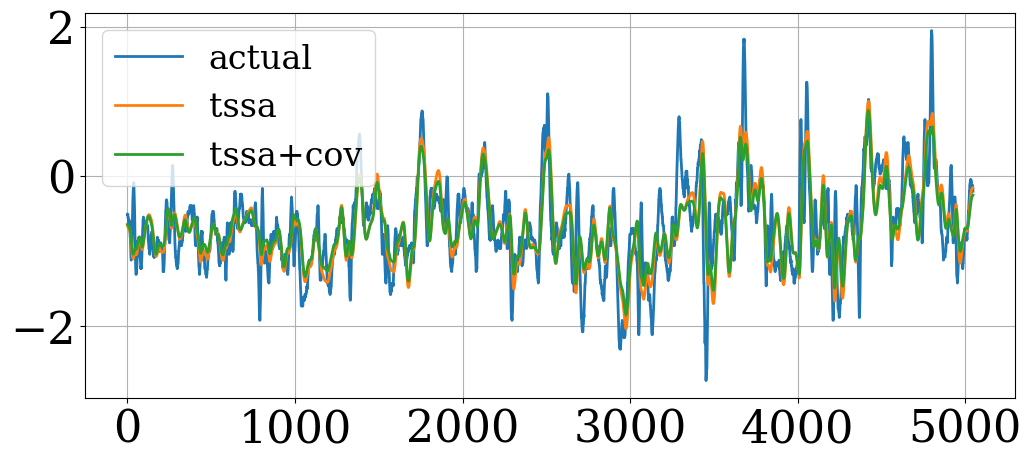

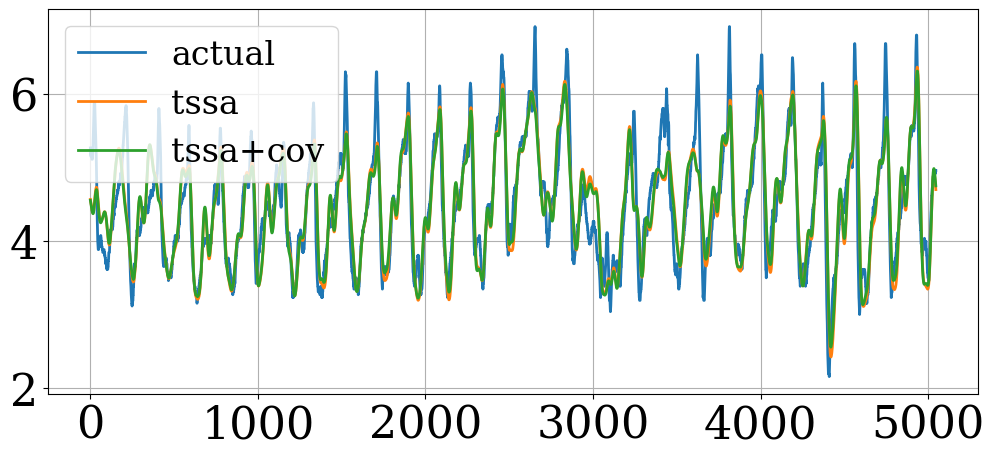

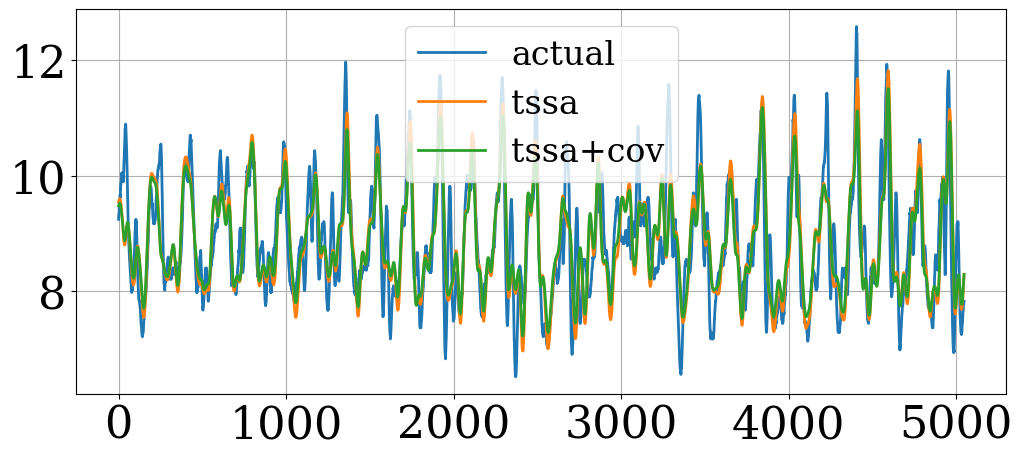

In [141]:
for i in range(actual_train_ts.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(y_train.T[i], label='actual')
        ax.plot(predicted_ts.T[i, :y_train.shape[0]], label='tssa')
        ax.plot(y_pred_train.T[i], label='tssa+cov')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

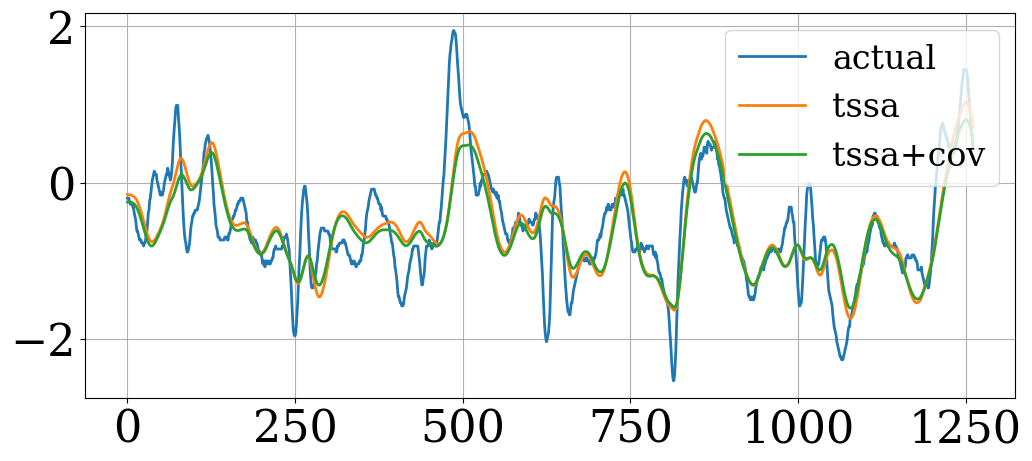

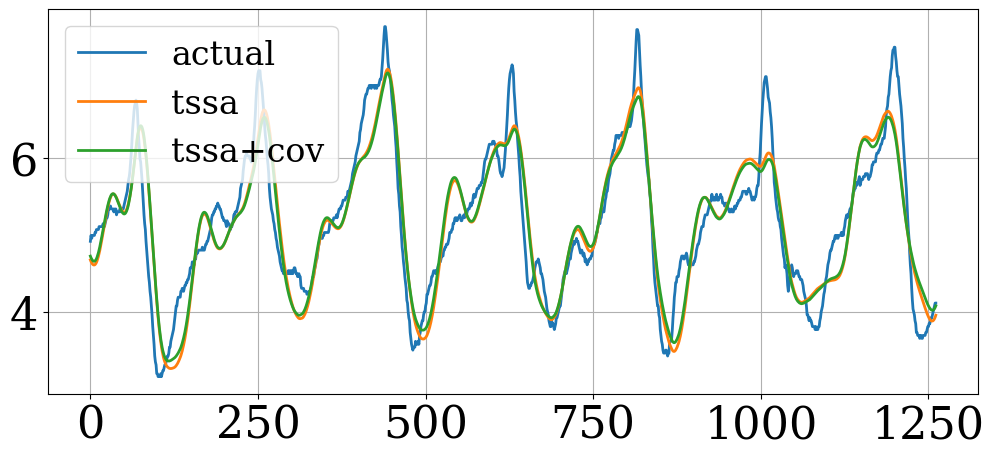

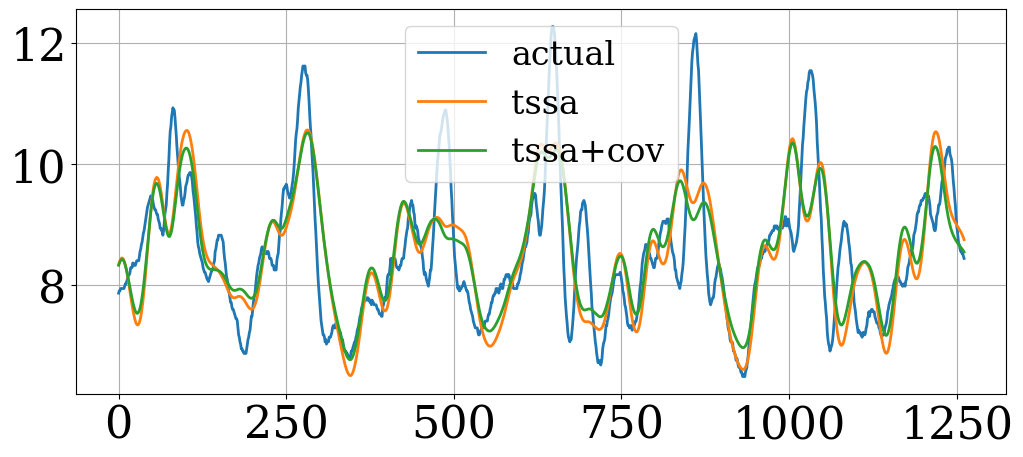

In [142]:
for i in range(actual_train_ts.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(y_test.T[i], label='actual')
        ax.plot(predicted_ts.T[i, y_train.shape[0]:], label='tssa')
        ax.plot(y_pred_test.T[i], label='tssa+cov')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

Как видим, удалось немного улучшить качество прогноза, хотя это и не очень очевидно по графикам.

In [133]:
weights = linear_reg.coef_
bias = linear_reg.intercept_

print("Веса (коэффициенты):", weights)
print("Свободный член (intercept):", bias)

Веса (коэффициенты): [[ 0.40322428 -0.030467    0.0228128  -0.0306252   0.00684598  0.03966804
  -0.00154075 -0.07704952  0.03925718]
 [ 0.02988922  0.71496505 -0.02252963 -0.02507646 -0.02256042 -0.01880858
  -0.02303203 -0.04300542  0.02337503]
 [-0.07119717  0.02994526  0.79959786 -0.02007184 -0.01685651  0.00868954
   0.05938191  0.00244145 -0.05163427]]
Свободный член (intercept): [-0.67479338  4.4900711   8.86240313]


In [88]:
pd.DataFrame(tsp_X_1).describe()

0            1            2            3            4  \
count  6309.000000  6309.000000  6309.000000  6309.000000  6309.000000   
mean     -0.000102     0.000034    -0.000052    -0.000061     0.000008   
std       0.516006     0.298049     0.197311     0.288464     0.230184   
min      -1.264524    -0.774598    -0.407122    -0.719918    -0.773489   
25%      -0.353732    -0.183407    -0.162500    -0.107141    -0.092353   
50%       0.157546     0.019580     0.014757     0.039175     0.051413   
75%       0.402054     0.192440     0.157093     0.226864     0.157335   
max       0.812428     0.699484     0.429099     0.522232     0.405179   

                 5  
count  6309.000000  
mean     -0.000034  
std       0.292603  
min      -0.769429  
25%      -0.220035  
50%       0.054498  
75%       0.228686  
max       0.483300